In [1]:
from utils.kernel import RBFKernel, LinearKernel, Matern52Kernel
from utils.gaussian_process import GaussianProcess as GP
import numpy as np
import pandas as pd
import scanpy as sc
import os
import scvelo as scv
import matplotlib.pyplot as plt
import random
random.seed(13)
np.random.seed(13)

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=120)

scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==0.24.2 scikit-learn==0.22.1 statsmodels==0.11.0rc1 python-igraph==0.7.1 louvain==0.6.1


In [64]:
adata = scv.datasets.dentategyrus()
adata

AnnData object with n_obs × n_vars = 2930 × 13913 
    obs: 'clusters', 'age(days)', 'clusters_enlarged'
    uns: 'clusters_colors'
    obsm: 'X_umap'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [4]:
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=3000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 11019 genes that are detected in less than 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`
Logarithmized X.
computing PCA with n_comps = 30
    finished (0:00:00)
computing neighbors
    finished (0:00:01) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)


In [5]:
# scv.tl.recover_dynamics(adata)

In [6]:
# scv.tl.velocity(adata, mode='dynamical')

In [7]:
# scv.tl.velocity_graph(adata)

In [3]:
### Check Point
# adata.write("write/dentate_gyrus_dynamical.h5ad")
adata = sc.read_h5ad("write/dentate_gyrus_dynamical.h5ad")

In [4]:
adata

AnnData object with n_obs × n_vars = 2930 × 2894 
    obs: 'clusters', 'age(days)', 'clusters_enlarged', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'clusters_colors', 'neighbors', 'pca', 'recover_dynamics', 'velocity_graph', 'velocity_graph_neg', 'velocity_settings'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs', 'loss'
    layers: 'Ms', 'Mu', 'ambiguous', 'fit_t', 'fit_tau', 'fit_tau_', 'spliced', 'unspliced', 'velocity', 'velocity_u'

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


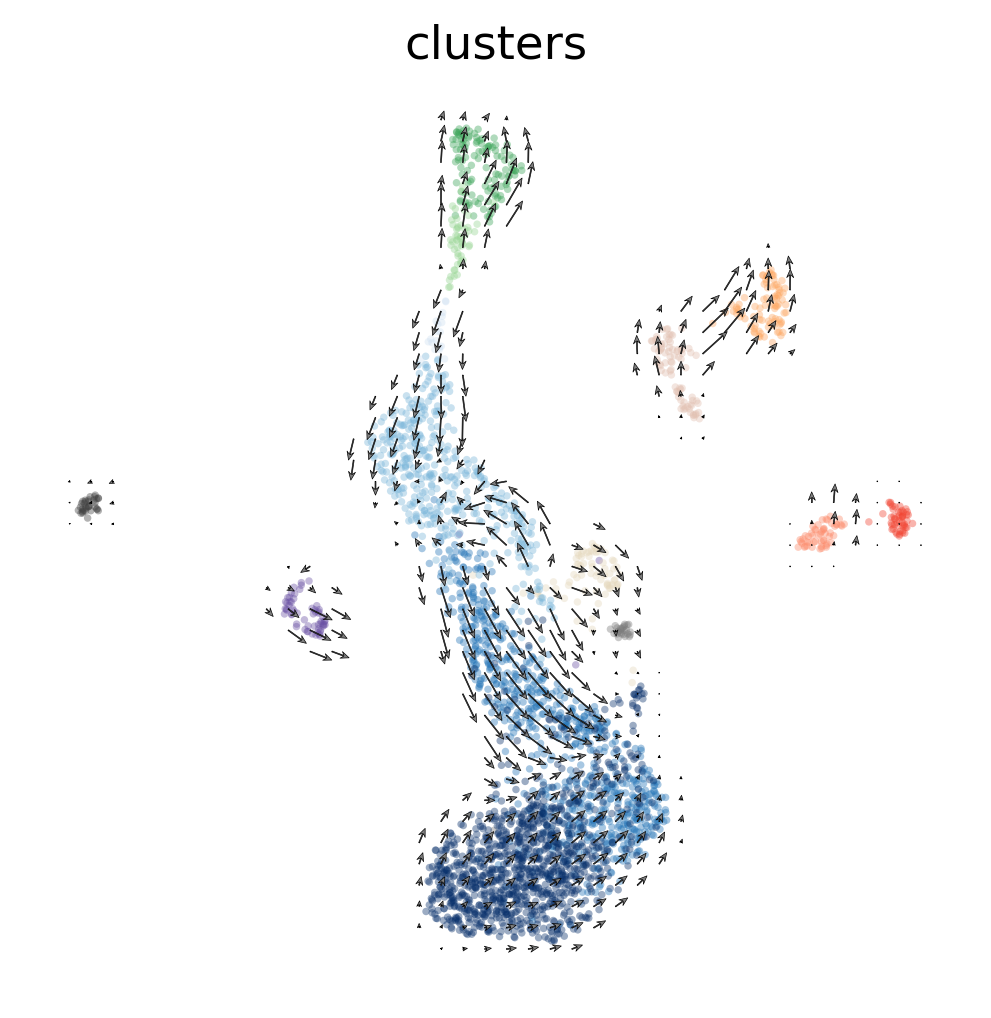

In [5]:
scv.pl.velocity_embedding_grid(adata, basis='umap', figsize=(5, 5), alpha=0.4, arrow_length=1.7, density=0.8, size=20,
                               arrow_size=1.5, dpi=120)

Counts:  8479420
0s counts:  6601228
non 0s counts:  1878192
Sum:  1709805.4
Mean:  0.91034645
Std:  0.49562234
Max:  6.4311533
Min:  0.0



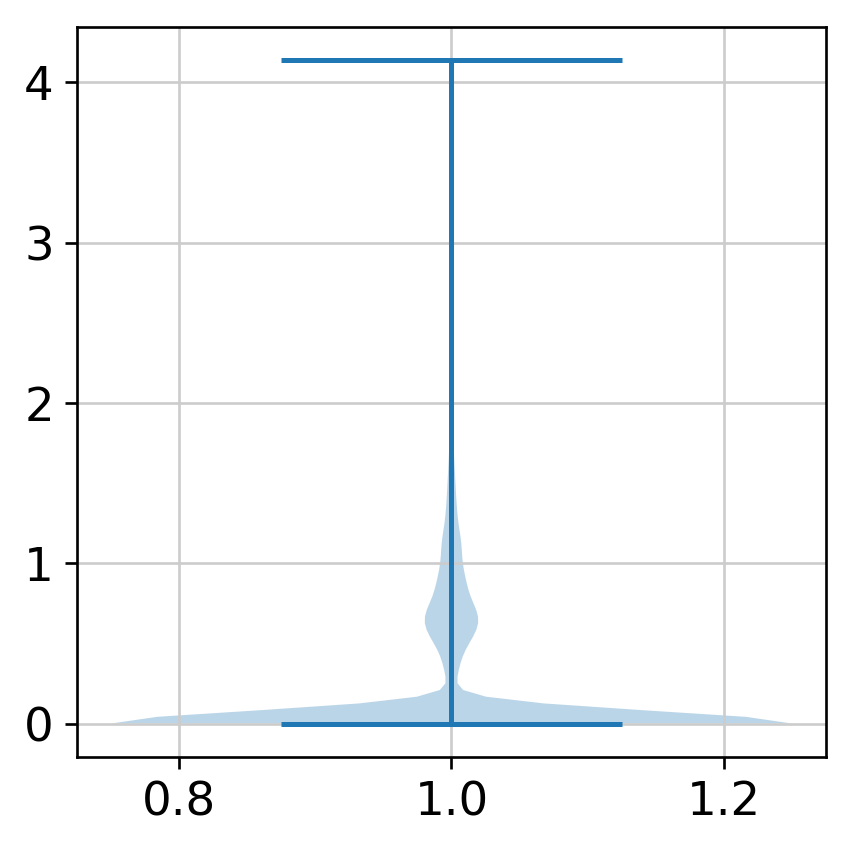

In [6]:
# statistics
data = adata.X.A
print("Counts: ", data.shape[0] * data.shape[1])
print("0s counts: ", np.sum(data == 0.0)) 
print("non 0s counts: ", np.sum(data != 0.0))
print("Sum: ", np.sum(data[data != 0.0]))
print("Mean: ", np.mean(data[data != 0.0])) 
print("Std: ", np.std(data[data != 0.0]))
print("Max: ", np.max(data))
print("Min: ", np.min(data))
random_data = np.random.choice(np.ravel(data), 5000)
plt.violinplot(random_data)
print()

Mean:  0.1914554120574847
Std:  0.42447535148809656
Max:  4.137275417046567
Min:  -0.00038371467334470384


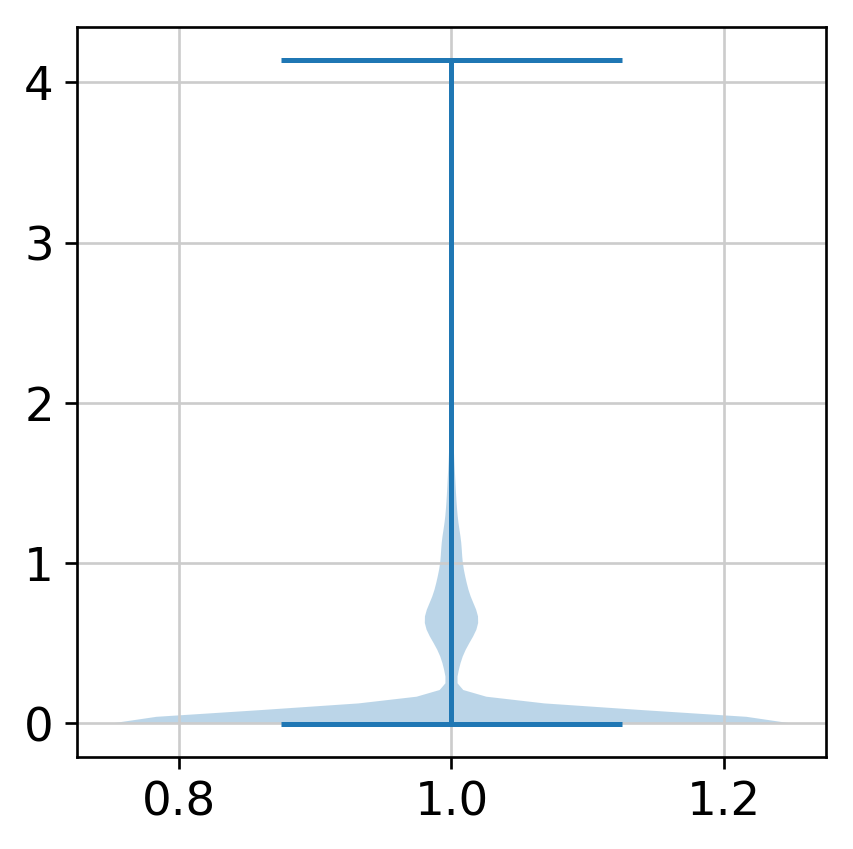

In [7]:
noiseless = random_data - np.random.randn(5000)*1e-4
plt.violinplot(noiseless)
print("Mean: ", np.mean(noiseless))
print("Std: ", np.std(noiseless))
print("Max: ", np.max(noiseless))
print("Min: ", np.min(noiseless))

In [8]:
def loss(true, pred, penalize_0s=True):
    error = np.square(true - pred)
    if not penalize_0s:
        error =  error[true != 0]
    return np.sqrt(np.mean(error))

In [9]:
scv.tl.rank_velocity_genes(adata, match_with='clusters', resolution=.4)

computing velocity clusters
    finished (0:00:01) --> added 
    'velocity_clusters', clusters based on modularity on velocity field (adata.obs)
ranking velocity genes
    finished (0:00:00) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns)


In [10]:
pd.DataFrame(adata.uns['rank_velocity_genes']['names'])

Granule mature 0 Granule mature 1   Neuroblast 2 Granule immature 3  \
0              Clu          Igfbpl1          Kif5c            Igfbpl1   
1           Ahcyl2              Clu  D430041D05Rik               Ddx1   
2            Slit1            Celf2         Ctnnd2                Cpe   
3          Slc6a15             Ddx1           Rcc2            Dnajc15   
4            Celf2            Foxk2          Mef2c              Foxk2   
5            Trpc6          Dnajc15          Prkce               Cdh9   
6           Crtac1          Slc6a15        Slc38a2               Fsd1   
7    2010300C02Rik           Gtf2h2        Slc43a2             Brinp1   
8            Grasp          Sparcl1          Cplx2              Ndst4   
9              Me3             Fsd1          Trim2              Reps2   

  Granule mature 4 Granule immature 5 Astrocytes 6   Mossy 7  \
0            Trpc6             Atp1a2       Map4k4  Aurkaip1   
1            Celf2              Unc80           Qk     Cox5a   
2          Slc6a15              Ift81        Fars2      Uri1   
3            Slit1           B4galnt4     Serpine2     Ift57   
4            Pcsk2           Itgb1bp1        Cspg5      Fgf5   
5            Grasp              Matr3          Ptn     Nol11   
6             Fsd1             Pcdh17       Mrpl52    Rpl37a   
7            Stmn4              Nrxn1        Rps24    Rgs7bp   
8           Csrnp3              Gcnt2       Zbtb20     Csmd2   
9          Hdgfrp3              Sorl1       Myo18a      Rpl5   

  Granule immature 8 Granule immature 9 Microglia 10 Neuroblast 11  \
0              Ift81               Ano3       Eif3j1           Tro   
1              Faim2              Celf4        Smdt1         Sec62   
2           B4galnt4            Ndufa11      Smarcc1         Myo16   
3              Unc80              Uhrf2       R3hdm4        Kcnab2   
4           Cntnap5a              Car10         Llph          Zeb2   
5            Col25a1             Vps13a         Rpl5        Atp5c1   
6           Itgb1bp1            Prkar2b         Dlat         Brwd1   
7            Slc12a5               Cyc1        Serf2         Prkce   
8             Lancl1            Gm10010         Gnas         Mllt4   
9             Asphd2             Lancl1          Hn1        Clasrp   

  Endothelial 12    OL 13   OPC 14 Neuroblast 15 Cajal Retzius 16 Cck-Tox 17  
0         Nfkbia    Rps11    Mrps5         Rab24         Mphosph8      Rps13  
1          Rps25    Rpl18    Dpp10            Cs          Zcchc17    Fam136a  
2          Clic4   Saysd1    Rps23      Mapk8ip2              Mt2      Rps16  
3          Glud1    Rps10    Rab24         Daam1            Dpp10     Ogfrl1  
4        Anapc13   Kansl2    Soga3         Prkce              Son      Nrxn3  
5          Arid2  Hepacam  Skiv2l2           Mt1           Tcerg1         Cs  
6       Serpine2    Serf2    Numa1         Rltpr             Bzw1      Rpl36  
7          Prex2  Apoa1bp   Slc1a3        Clasp2            Lage3      Ptprn  
8          Rpl17  Anapc13     Wasl         Crlf1             Cdh2       Amph  
9          Rpl37     Sdhb     Ten1        Rbfox3            Arid2       Rpl5

In [11]:
scv.tl.recover_latent_time(adata)

computing terminal states
    identified 1 region of root cells and 4 regions of end points 
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


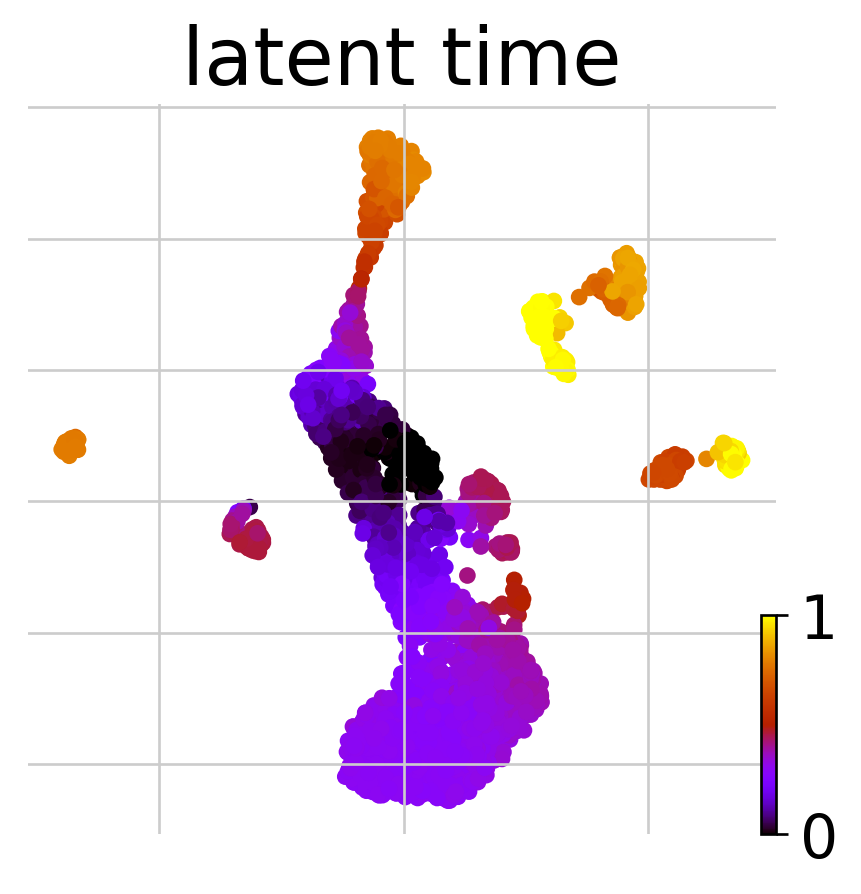

In [26]:
scv.pl.scatter(adata, color='latent_time', fontsize=24, size=100,
               color_map='gnuplot', perc=[2, 98], colorbar=True, rescale_color=[0,1])

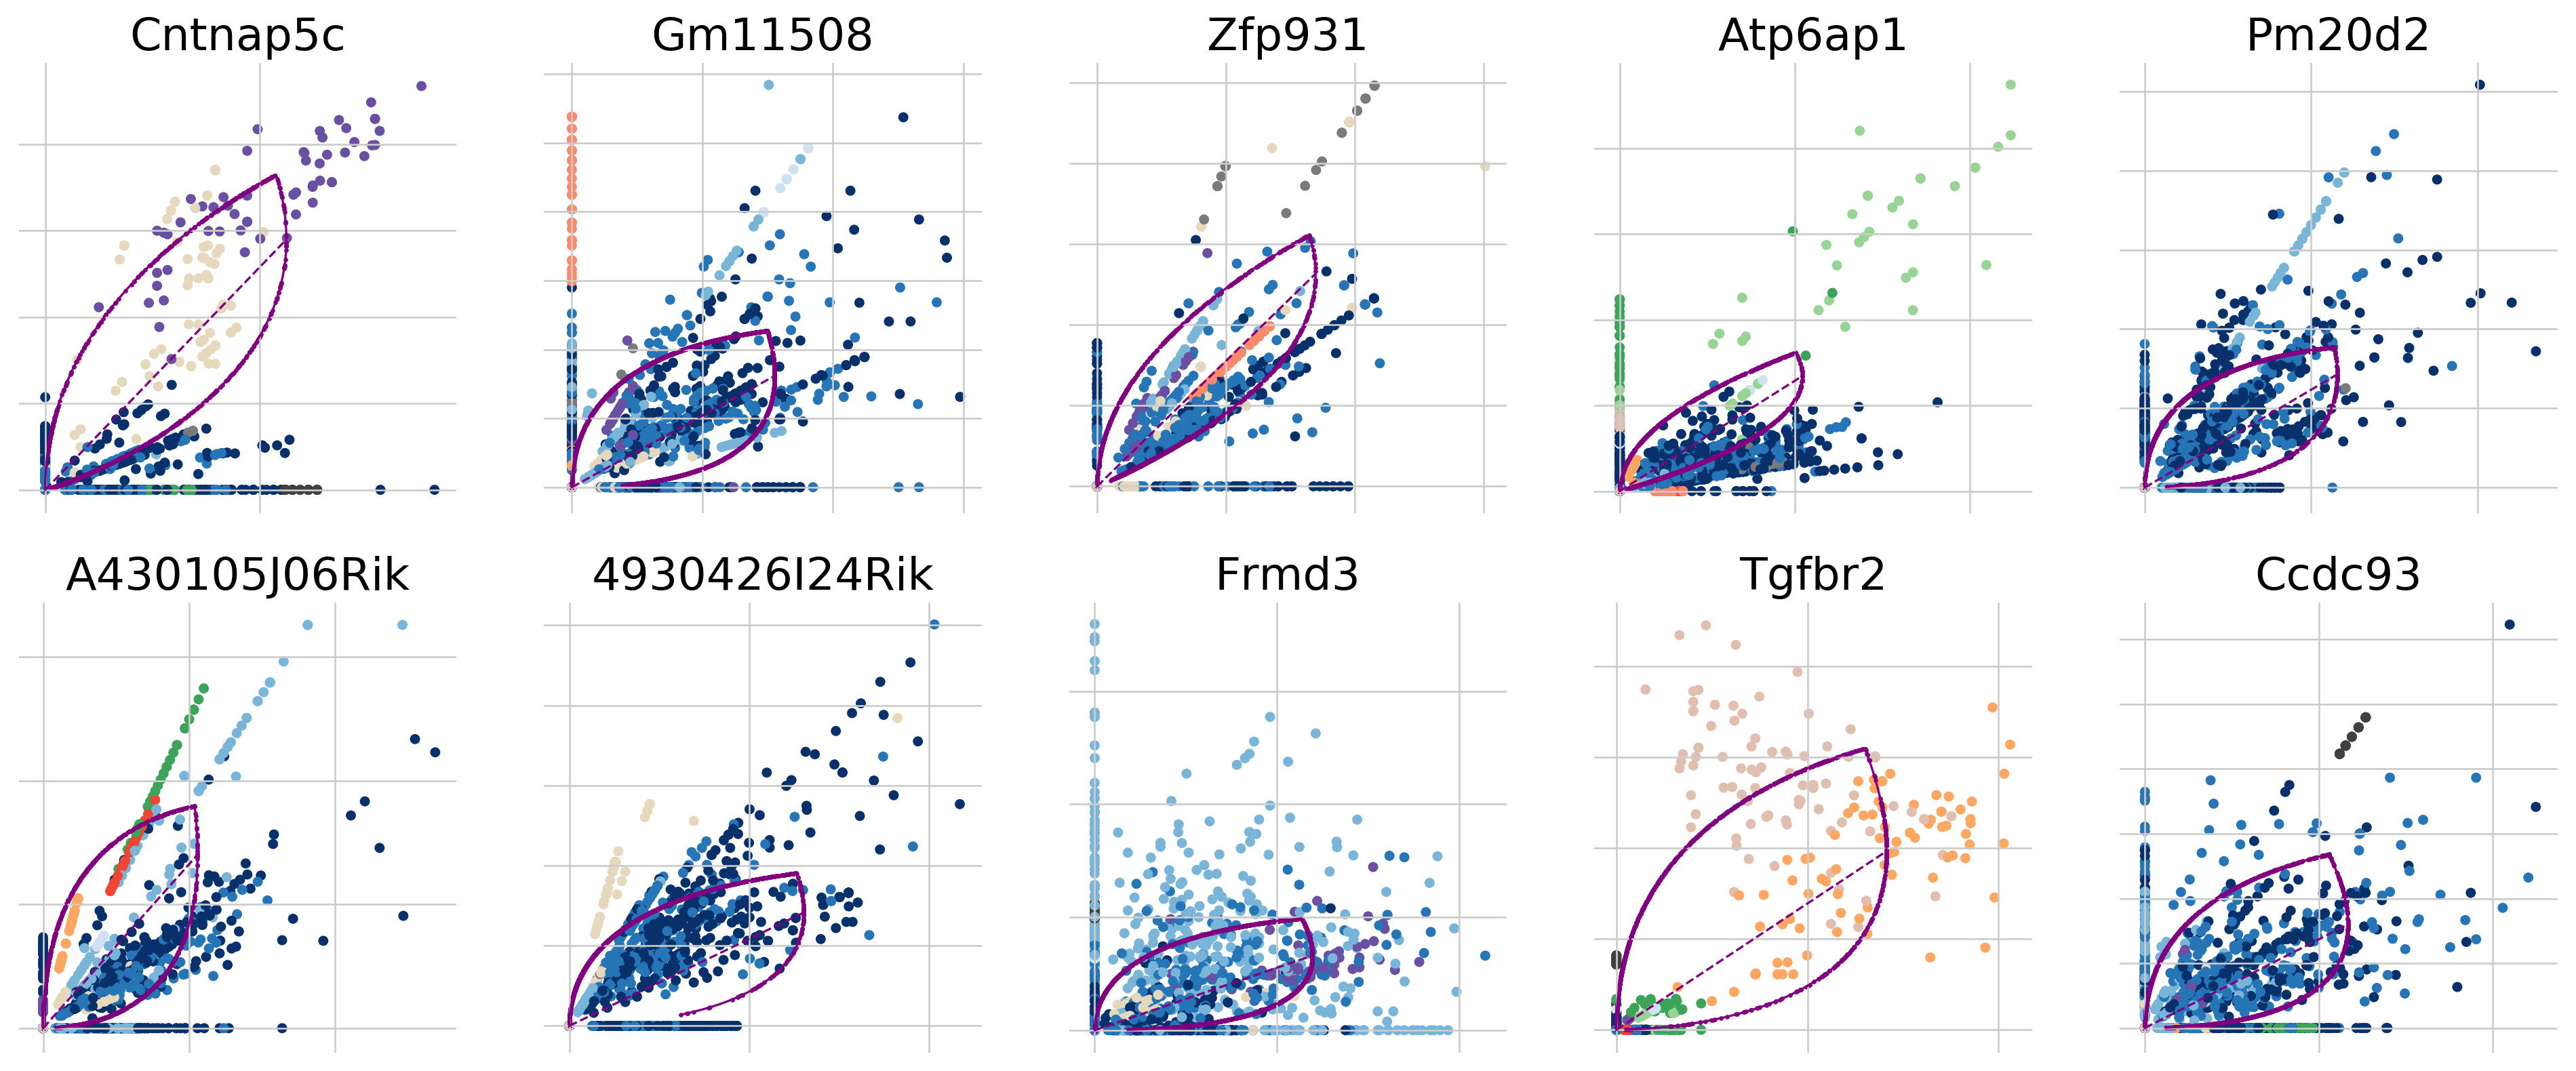

In [27]:
scv.pl.scatter(adata, basis=['Cntnap5c',
 'Gm11508',
 'Zfp931',
 'Atp6ap1',
 'Pm20d2',
 'A430105J06Rik',
 '4930426I24Rik',
 'Frmd3',
 'Tgfbr2',
 'Ccdc93'], legend_loc='none',
               size=80, frameon=False, ncols=5, fontsize=20, colorbar=True)

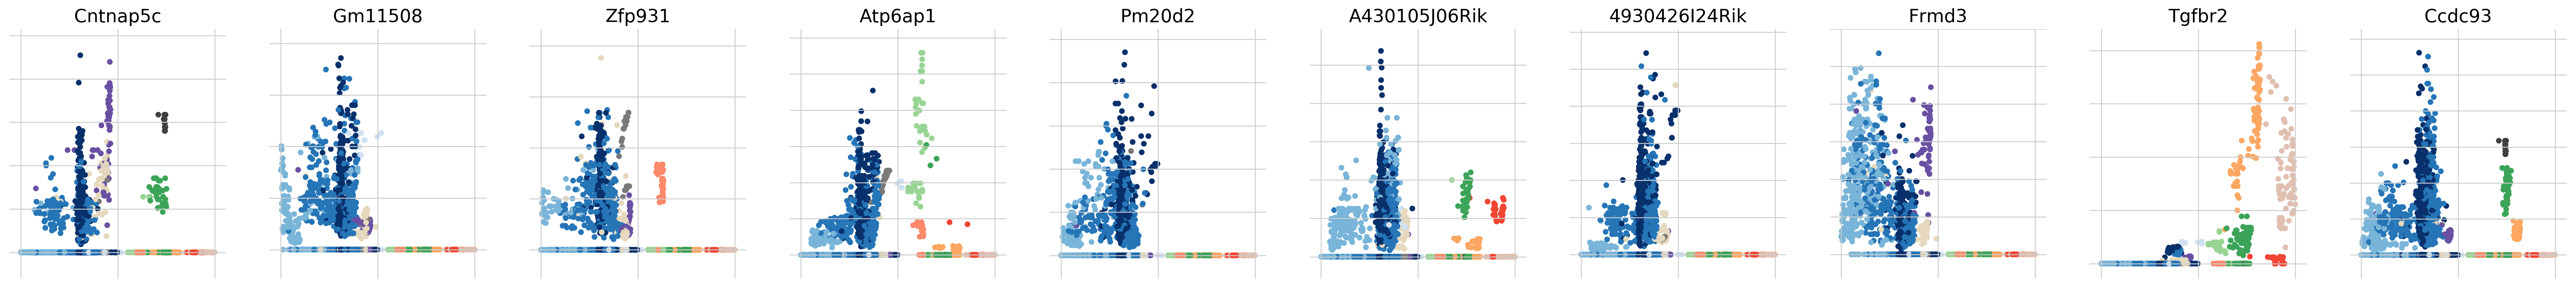

In [22]:
scv.pl.scatter(adata, x='latent_time', y=['Cntnap5c',
 'Gm11508',
 'Zfp931',
 'Atp6ap1',
 'Pm20d2',
 'A430105J06Rik',
 '4930426I24Rik',
 'Frmd3',
 'Tgfbr2',
 'Ccdc93'], fontsize=16, size=100,
               n_convolve=None, frameon=False, legend_loc='none', color_map='gnuplot')

# Baseline Gassian Process

    1. Using the RBF (Squared Exponent) Kernel
    2. 70% of dataset as it's smaller as it's very sparse
    3. Optimize only for first gene in list

In [16]:
kernel = RBFKernel(alpha=0.1, gamma=1)
gp = GP(kernel=kernel, alpha=1e-4, optimize=True, restarts=0)

In [17]:
genes = {gene:i for i, gene in enumerate(list(adata.var["velocity_genes"].index)) if adata.var["velocity_genes"][gene]}
GENES = list(genes.keys())

In [18]:
error = []
error_weighted = []

X = adata.obsm["X_umap"][:, :2]

In [19]:
#### Optimize for random gene
random_gene = np.random.choice(GENES)
print(random_gene)
y = adata.X.A[:, genes[random_gene]].reshape(-1)
Y = y
gp.fit(X, Y.reshape(-1, 1), sample_ratio=0.7)
kernel.gamma

Sh3kbp1


array([1., 1.])

In [20]:
#### Fit On All Genes
data = adata.X.A
for gene in GENES:
    y = data[:, genes[gene]].reshape(-1)
    Y = y
    gp.fit(X, Y.reshape(-1, 1), sample_ratio=0.7)
    gp.log_marginal_likelihood(gene, info=True)
    pred = gp.predict(X)
    error.append(loss(y, pred, penalize_0s=True))
    error_weighted.append(loss(y, pred, penalize_0s=False))

Gene: Prex2        Marginal Likelihood: [-1913.31573429]
Gene: A830018L16Rik Marginal Likelihood: [-1928.18363863]
Gene: Hs6st1       Marginal Likelihood: [-1919.88759086]
Gene: Rpl31        Marginal Likelihood: [-2208.47303032]
Gene: Map4k4       Marginal Likelihood: [-1933.92024879]
Gene: Gm10561      Marginal Likelihood: [-1895.98408092]
Gene: Bzw1         Marginal Likelihood: [-1930.58174692]
Gene: Nop58        Marginal Likelihood: [-1940.389609]
Gene: Nrp2         Marginal Likelihood: [-1956.84299493]
Gene: Unc80        Marginal Likelihood: [-2023.04402715]
Gene: Rpl37a       Marginal Likelihood: [-2464.65646127]
Gene: Arpc2        Marginal Likelihood: [-2262.17353971]
Gene: Fam134a      Marginal Likelihood: [-2005.18066758]
Gene: 2810459M11Rik Marginal Likelihood: [-1908.31518372]
Gene: Ube2f        Marginal Likelihood: [-1963.29295293]
Gene: Asb1         Marginal Likelihood: [-1906.19818319]
Gene: Fam174a      Marginal Likelihood: [-2120.61833781]
Gene: Cntnap5a     Marginal Lik

Gene: Skp1a        Marginal Likelihood: [-2043.48739633]
Gene: Acsl6        Marginal Likelihood: [-1925.50684687]
Gene: Gria1        Marginal Likelihood: [-2178.69886224]
Gene: Larp1        Marginal Likelihood: [-1943.13471421]
Gene: Trpv2        Marginal Likelihood: [-1902.87310849]
Gene: Gps2         Marginal Likelihood: [-1957.45403885]
Gene: Rtn4rl1      Marginal Likelihood: [-1939.4089678]
Gene: Prpf8        Marginal Likelihood: [-1961.17354566]
Gene: Slc43a2      Marginal Likelihood: [-1941.98873406]
Gene: Myo18a       Marginal Likelihood: [-1932.08264087]
Gene: Flot2        Marginal Likelihood: [-1947.93323818]
Gene: Sept4        Marginal Likelihood: [-1937.57028857]
Gene: Mmd          Marginal Likelihood: [-2116.69489568]
Gene: Car10        Marginal Likelihood: [-1926.08166778]
Gene: Psmb3        Marginal Likelihood: [-2168.13380996]
Gene: Rapgefl1     Marginal Likelihood: [-1984.14655829]
Gene: Tubg2        Marginal Likelihood: [-1949.61482402]
Gene: Cntnap1      Marginal Like

Gene: Rgs7bp       Marginal Likelihood: [-2078.46379539]
Gene: Rab3c        Marginal Likelihood: [-1927.84431541]
Gene: Skiv2l2      Marginal Likelihood: [-1914.486271]
Gene: Ptprg        Marginal Likelihood: [-1930.34219508]
Gene: Synpr        Marginal Likelihood: [-2104.66611784]
Gene: Zswim8       Marginal Likelihood: [-1930.39751992]
Gene: Adk          Marginal Likelihood: [-1992.07938002]
Gene: Rps24        Marginal Likelihood: [-2438.40140234]
Gene: Selk         Marginal Likelihood: [-2316.50769855]
Gene: Glud1        Marginal Likelihood: [-2020.59292038]
Gene: Pnp          Marginal Likelihood: [-1916.69137716]
Gene: Mrpl52       Marginal Likelihood: [-2036.52158714]
Gene: Cmtm5        Marginal Likelihood: [-1933.72034814]
Gene: Lrrc16b      Marginal Likelihood: [-1909.24117169]
Gene: Cpne6        Marginal Likelihood: [-2053.80339615]
Gene: Irf9         Marginal Likelihood: [-1904.16576151]
Gene: Mphosph8     Marginal Likelihood: [-2015.44469524]
Gene: Pinx1        Marginal Likel

Gene: Zfp414       Marginal Likelihood: [-1959.65214559]
Gene: Atf6b        Marginal Likelihood: [-1986.02757891]
Gene: Ddah2        Marginal Likelihood: [-1968.55189087]
Gene: Gabbr1       Marginal Likelihood: [-2090.47098378]
Gene: Ptchd4       Marginal Likelihood: [-2003.96292126]
Gene: Fsd1         Marginal Likelihood: [-1958.40783328]
Gene: Mpnd         Marginal Likelihood: [-2035.35626172]
Gene: Hdgfrp2      Marginal Likelihood: [-1984.25932724]
Gene: Rpl36        Marginal Likelihood: [-2271.52602275]
Gene: Ndufa11      Marginal Likelihood: [-2186.04168001]
Gene: Dus3l        Marginal Likelihood: [-1946.99196283]
Gene: Cntnap5c     Marginal Likelihood: [-1887.35547197]
Gene: A330050F15Rik Marginal Likelihood: [-1919.78999265]
Gene: Dlgap1       Marginal Likelihood: [-2172.9521983]
Gene: Slc30a6      Marginal Likelihood: [-1905.95343511]
Gene: Gpatch11     Marginal Likelihood: [-1932.30327812]
Gene: Ndufaf7      Marginal Likelihood: [-1973.79069564]
Gene: Eml4         Marginal Lik

Gene: Mapre1       Marginal Likelihood: [-2078.01037324]
Gene: Romo1        Marginal Likelihood: [-2082.68071165]
Gene: Phf20        Marginal Likelihood: [-1990.64966906]
Gene: Ralgapb      Marginal Likelihood: [-1927.17639155]
Gene: Top1         Marginal Likelihood: [-2141.36807554]
Gene: Slc12a5      Marginal Likelihood: [-1997.41944426]
Gene: Gnas         Marginal Likelihood: [-2379.79454269]
Gene: Hspa14       Marginal Likelihood: [-1949.88926345]
Gene: Cdc123       Marginal Likelihood: [-2035.8101232]
Gene: Celf2        Marginal Likelihood: [-2175.96681272]
Gene: Atp5c1       Marginal Likelihood: [-2318.26498951]
Gene: Itga8        Marginal Likelihood: [-1909.46396472]
Gene: C1ql3        Marginal Likelihood: [-2148.4272895]
Gene: Dnajc1       Marginal Likelihood: [-1930.77773721]
Gene: Spopl        Marginal Likelihood: [-1911.11627498]
Gene: Cacna1b      Marginal Likelihood: [-1928.20169154]
Gene: Qsox2        Marginal Likelihood: [-1905.46878747]
Gene: Dnlz         Marginal Likel

Gene: Zcchc17      Marginal Likelihood: [-2161.62026815]
Gene: Clic4        Marginal Likelihood: [-1909.81673698]
Gene: Srrm1        Marginal Likelihood: [-2024.400246]
Gene: Cdc42        Marginal Likelihood: [-2137.80438525]
Gene: Crocc        Marginal Likelihood: [-1907.71876864]
Gene: Kcnab2       Marginal Likelihood: [-1996.78089624]
Gene: Fam213b      Marginal Likelihood: [-1997.15490407]
Gene: Agrn         Marginal Likelihood: [-1958.2399841]
Gene: Prdm8        Marginal Likelihood: [-1941.51343864]
Gene: Fgf5         Marginal Likelihood: [-1897.86257217]
Gene: D930016D06Rik Marginal Likelihood: [-1915.82228577]
Gene: Ephx4        Marginal Likelihood: [-2038.03369911]
Gene: Rpl5         Marginal Likelihood: [-2231.42561483]
Gene: Gm10419      Marginal Likelihood: [-1944.87049319]
Gene: Rpl6         Marginal Likelihood: [-2235.36389685]
Gene: Arpc3        Marginal Likelihood: [-2163.31373002]
Gene: Atp6v0a2     Marginal Likelihood: [-1895.29036838]
Gene: Gbas         Marginal Likel

Gene: Mrpl23       Marginal Likelihood: [-2074.13456821]
Gene: Tfpt         Marginal Likelihood: [-1957.7141189]
Gene: Tmem238      Marginal Likelihood: [-1914.75123331]
Gene: Chmp2a       Marginal Likelihood: [-2122.99824348]
Gene: Gltscr2      Marginal Likelihood: [-2112.73194136]
Gene: Gm26802      Marginal Likelihood: [-1899.40554596]
Gene: Fosb         Marginal Likelihood: [-1904.66564745]
Gene: Clasrp       Marginal Likelihood: [-1936.35746673]
Gene: Psmc4        Marginal Likelihood: [-2060.15089031]
Gene: Eif3k        Marginal Likelihood: [-2208.26339055]
Gene: Psenen       Marginal Likelihood: [-2071.88998396]
Gene: Cox6b1       Marginal Likelihood: [-2345.55708354]
Gene: Rbm42        Marginal Likelihood: [-1987.63020099]
Gene: Mag          Marginal Likelihood: [-1910.44957277]
Gene: Fxyd1        Marginal Likelihood: [-1937.38680502]
Gene: Uri1         Marginal Likelihood: [-1961.5951395]
Gene: Fcgrt        Marginal Likelihood: [-1935.67227702]
Gene: Rps11        Marginal Likel

Gene: Eif3g        Marginal Likelihood: [-2058.1508708]
Gene: Keap1        Marginal Likelihood: [-1971.57648481]
Gene: Dock6        Marginal Likelihood: [-1892.83960826]
Gene: Elavl3       Marginal Likelihood: [-2181.58359597]
Gene: Elof1        Marginal Likelihood: [-2068.21989393]
Gene: Rp9          Marginal Likelihood: [-2028.28104279]
Gene: Ntm          Marginal Likelihood: [-1942.36997891]
Gene: St3gal4      Marginal Likelihood: [-1916.91094032]
Gene: Ei24         Marginal Likelihood: [-2050.60497837]
Gene: Nrgn         Marginal Likelihood: [-2230.55995772]
Gene: Sorl1        Marginal Likelihood: [-2032.61934649]
Gene: Grik4        Marginal Likelihood: [-1932.26343454]
Gene: Trappc4      Marginal Likelihood: [-2099.75010185]
Gene: Pafah1b2     Marginal Likelihood: [-2034.45790567]
Gene: Zbtb16       Marginal Likelihood: [-1920.31203296]
Gene: Dlat         Marginal Likelihood: [-1992.27468737]
Gene: Elmod1       Marginal Likelihood: [-1964.75491443]
Gene: Dmxl2        Marginal Like

### Rank Genes by Smoothness

Get top and last 10 genes by smoothness

In [21]:
lh = gp.get_all_likelihoods()
top = list(zip(*sorted(list(lh.items()), key=lambda x:x[1], reverse=True)))[0]
last = top[::-1]
top[:10]

('Cntnap5c',
 'Gm11508',
 'Zfp931',
 'Atp6ap1',
 'Pm20d2',
 'A430105J06Rik',
 '4930426I24Rik',
 'Frmd3',
 'Tgfbr2',
 'Ccdc93')

In [22]:
last[:10]

('Tmsb10',
 'Slc25a4',
 'Rps23',
 'Rpl17',
 'Rpl37a',
 'Rpl37',
 'Rps27',
 'Rps16',
 'Rps24',
 'Rps11')

### Inspect Corelation Between Genes

Plot the correlation between top 3:

    1. smoothest and least smooth genes
    2. smoothest and smoothest genes
    3. lest smooth and leat smooth genes

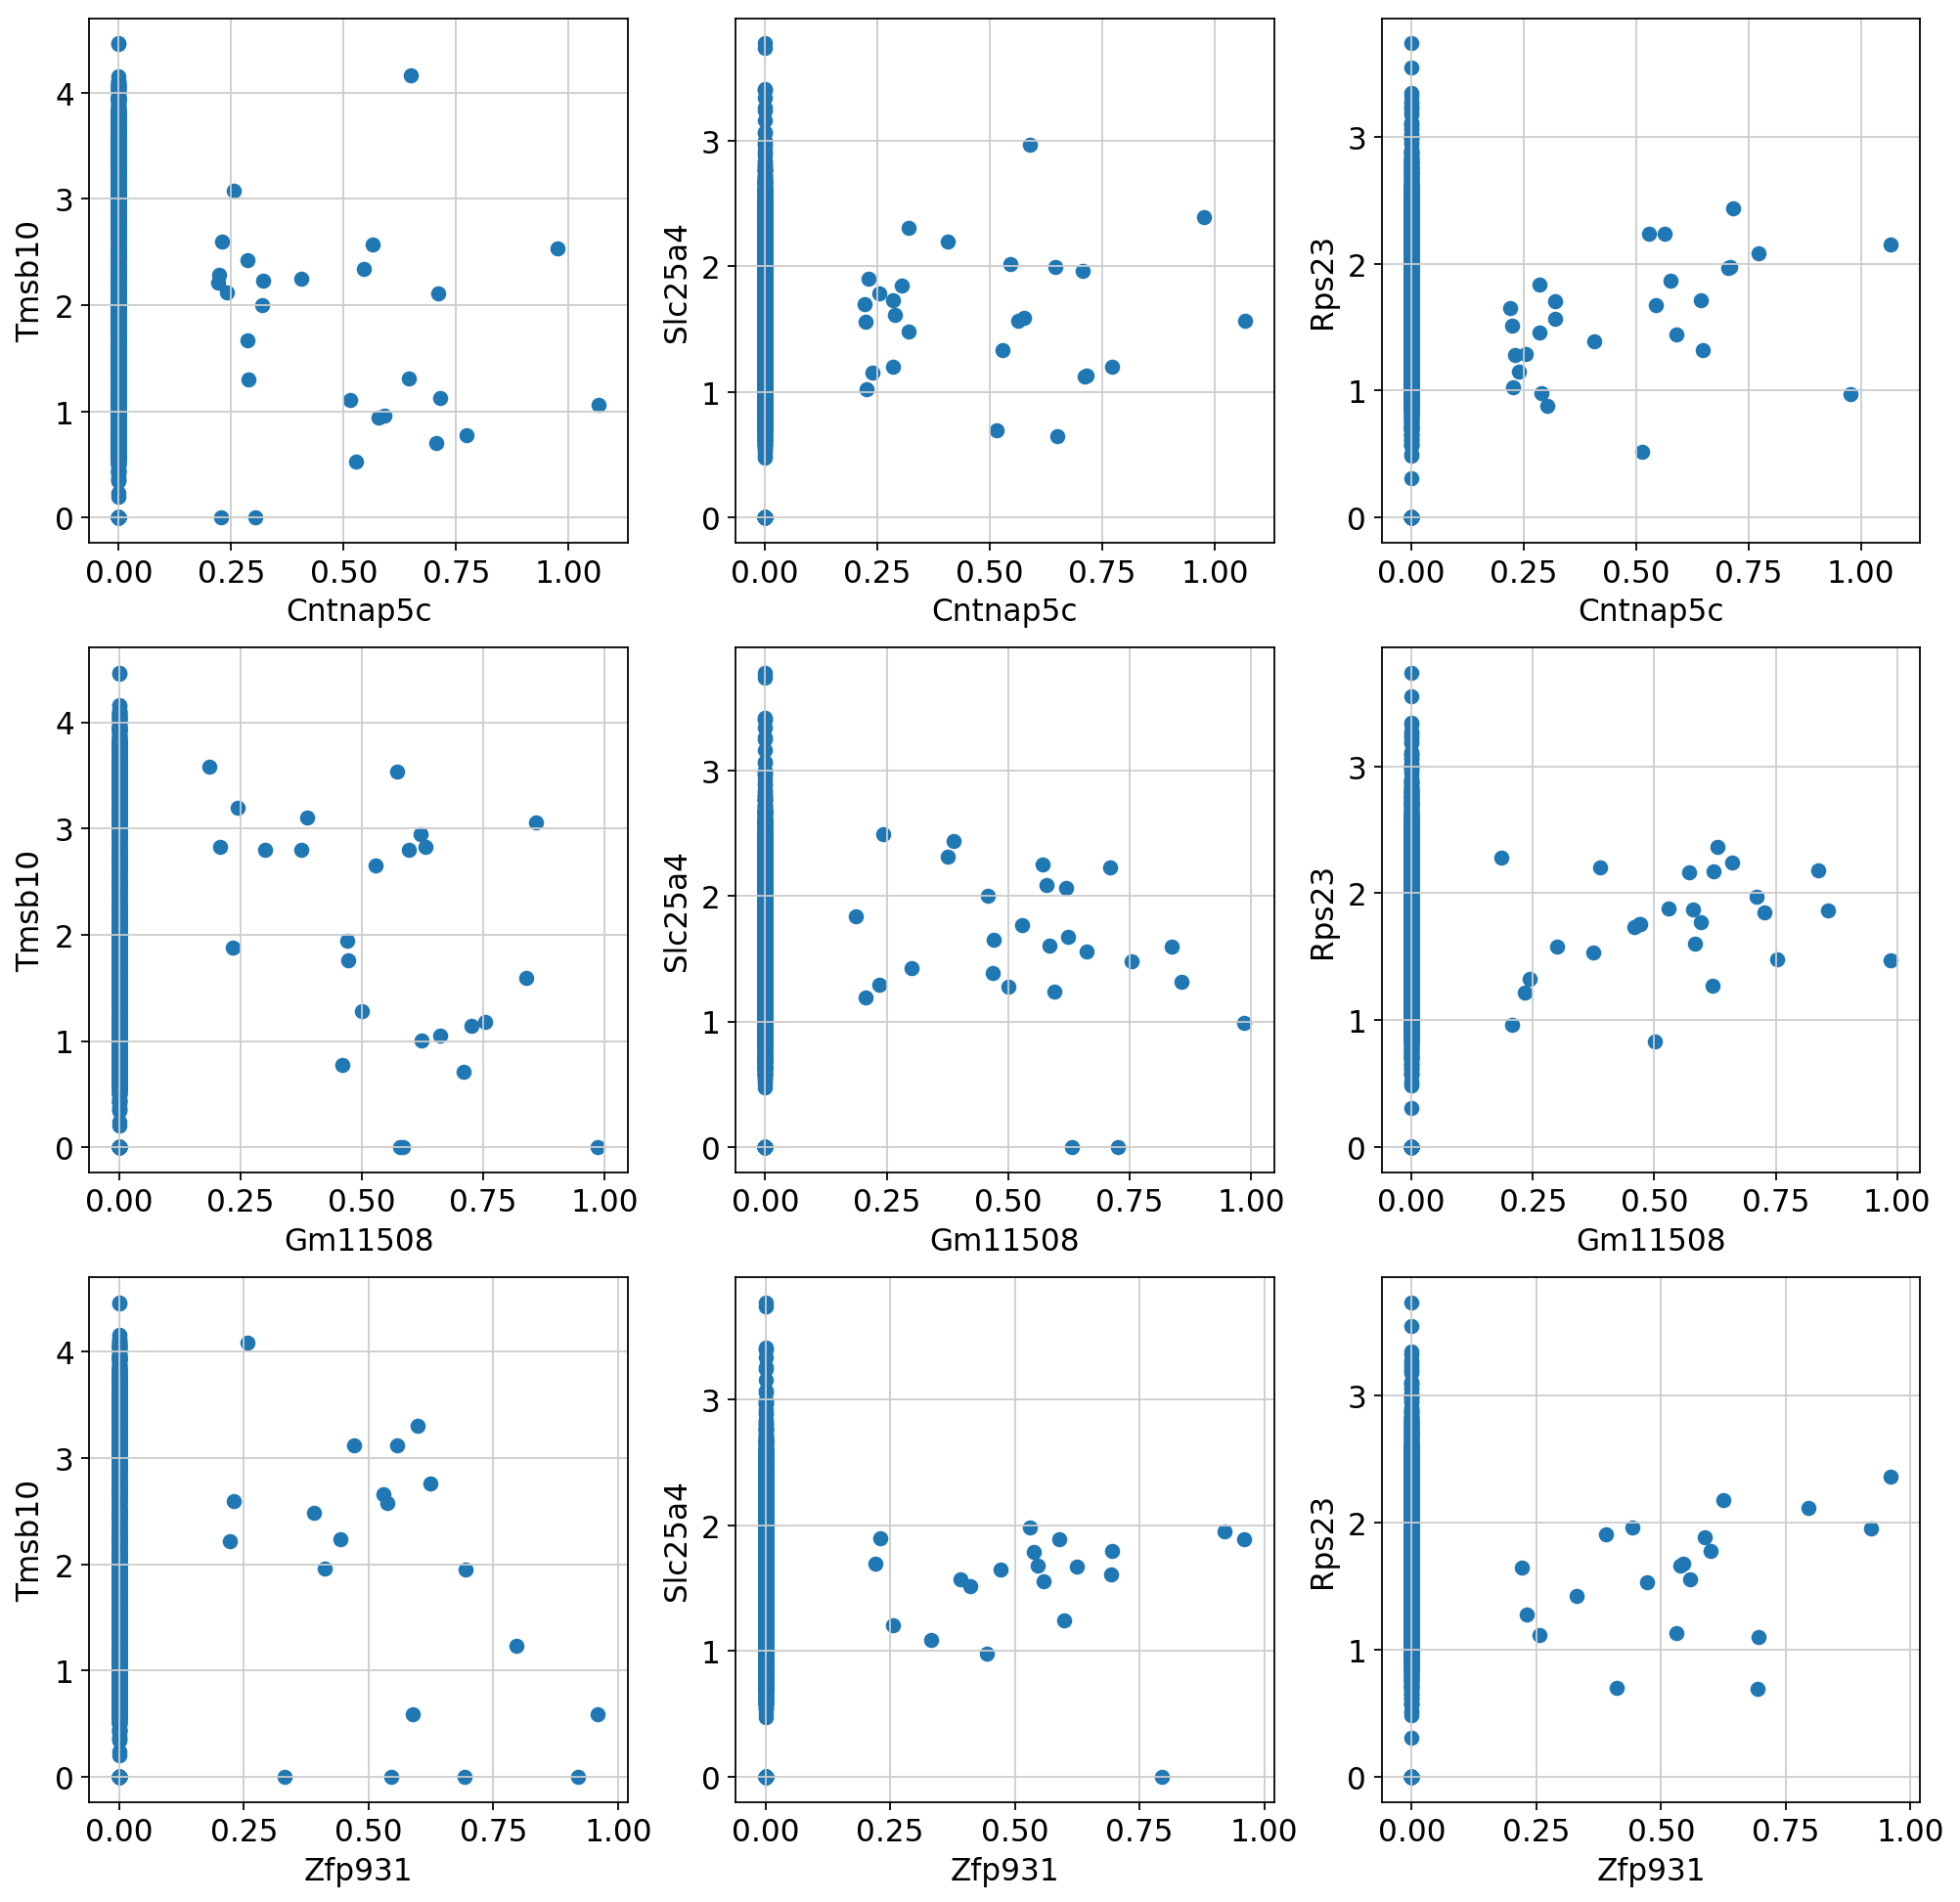

In [23]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i, genei in enumerate(top[:3]):
    for j, genej in enumerate(last[:3]):
        ax[i][j].scatter(adata.X[:, genes[genei]].A, adata.X[:, genes[genej]].A)
        ax[i][j].set_xlabel(genei)
        ax[i][j].set_ylabel(genej)

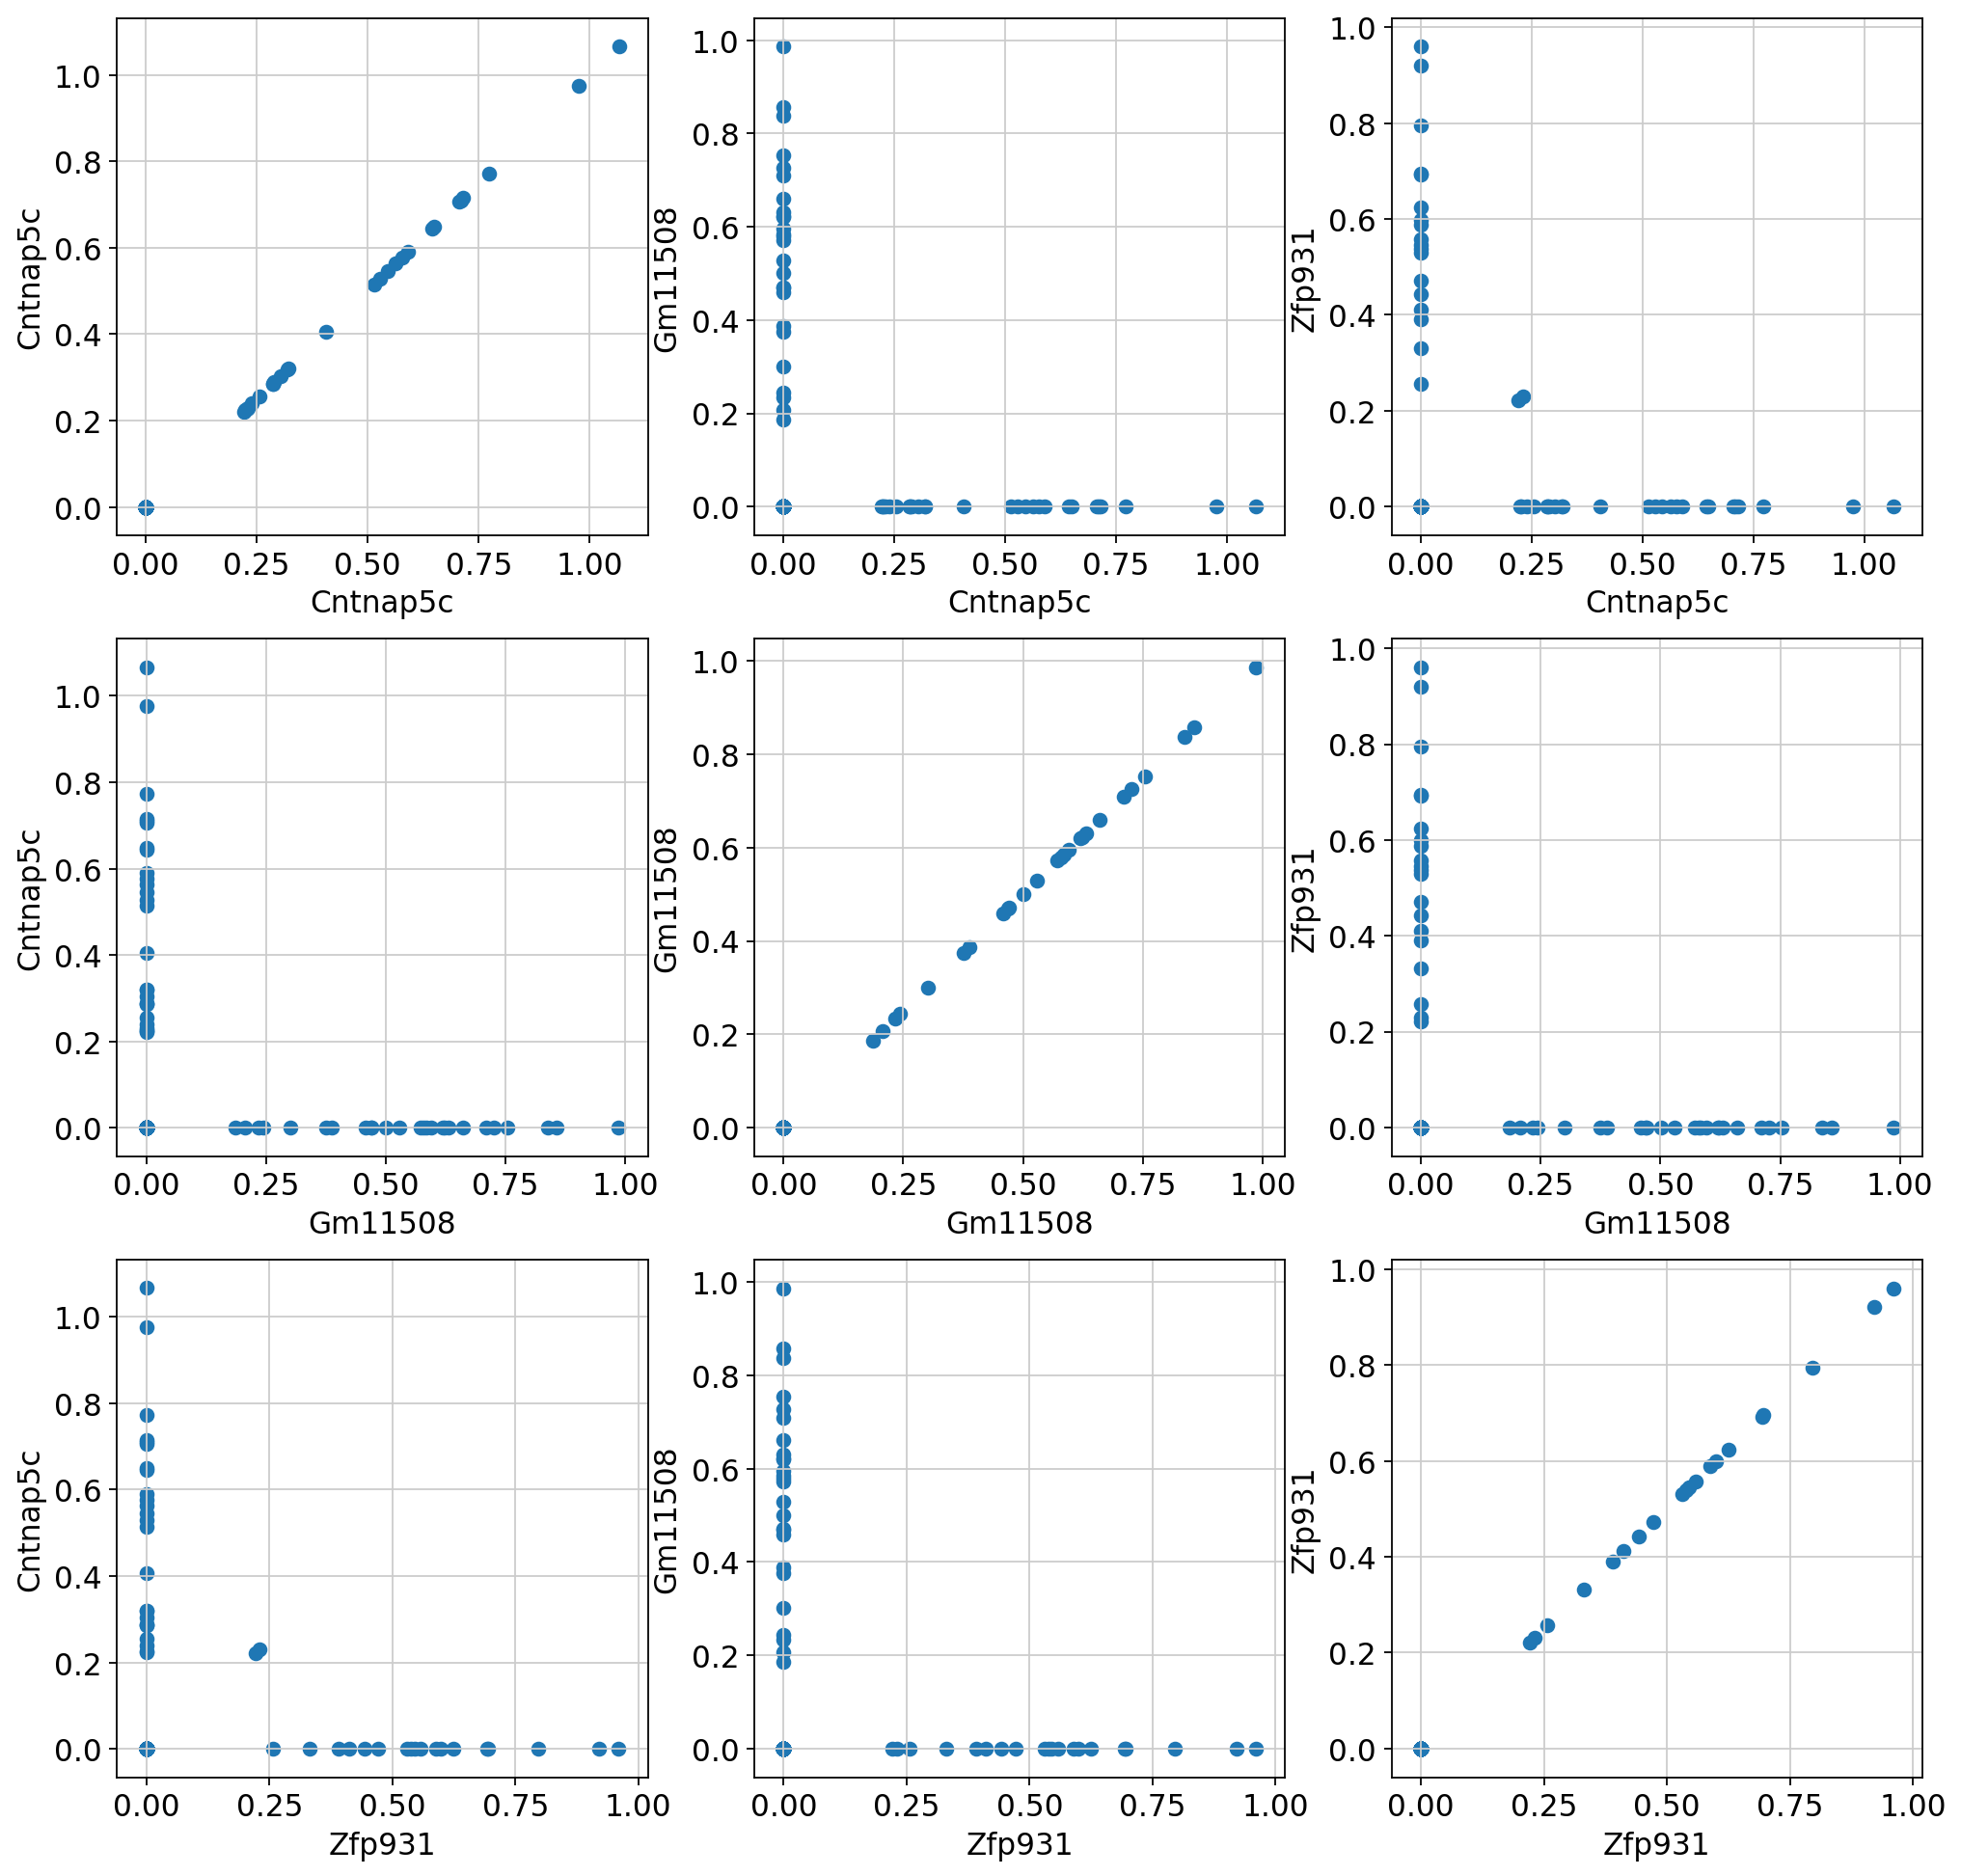

In [24]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i, genei in enumerate(top[:3]):
    for j, genej in enumerate(top[:3]):
        ax[i][j].scatter(adata.X[:, genes[genei]].A, adata.X[:, genes[genej]].A)
        ax[i][j].set_xlabel(genei)
        ax[i][j].set_ylabel(genej)

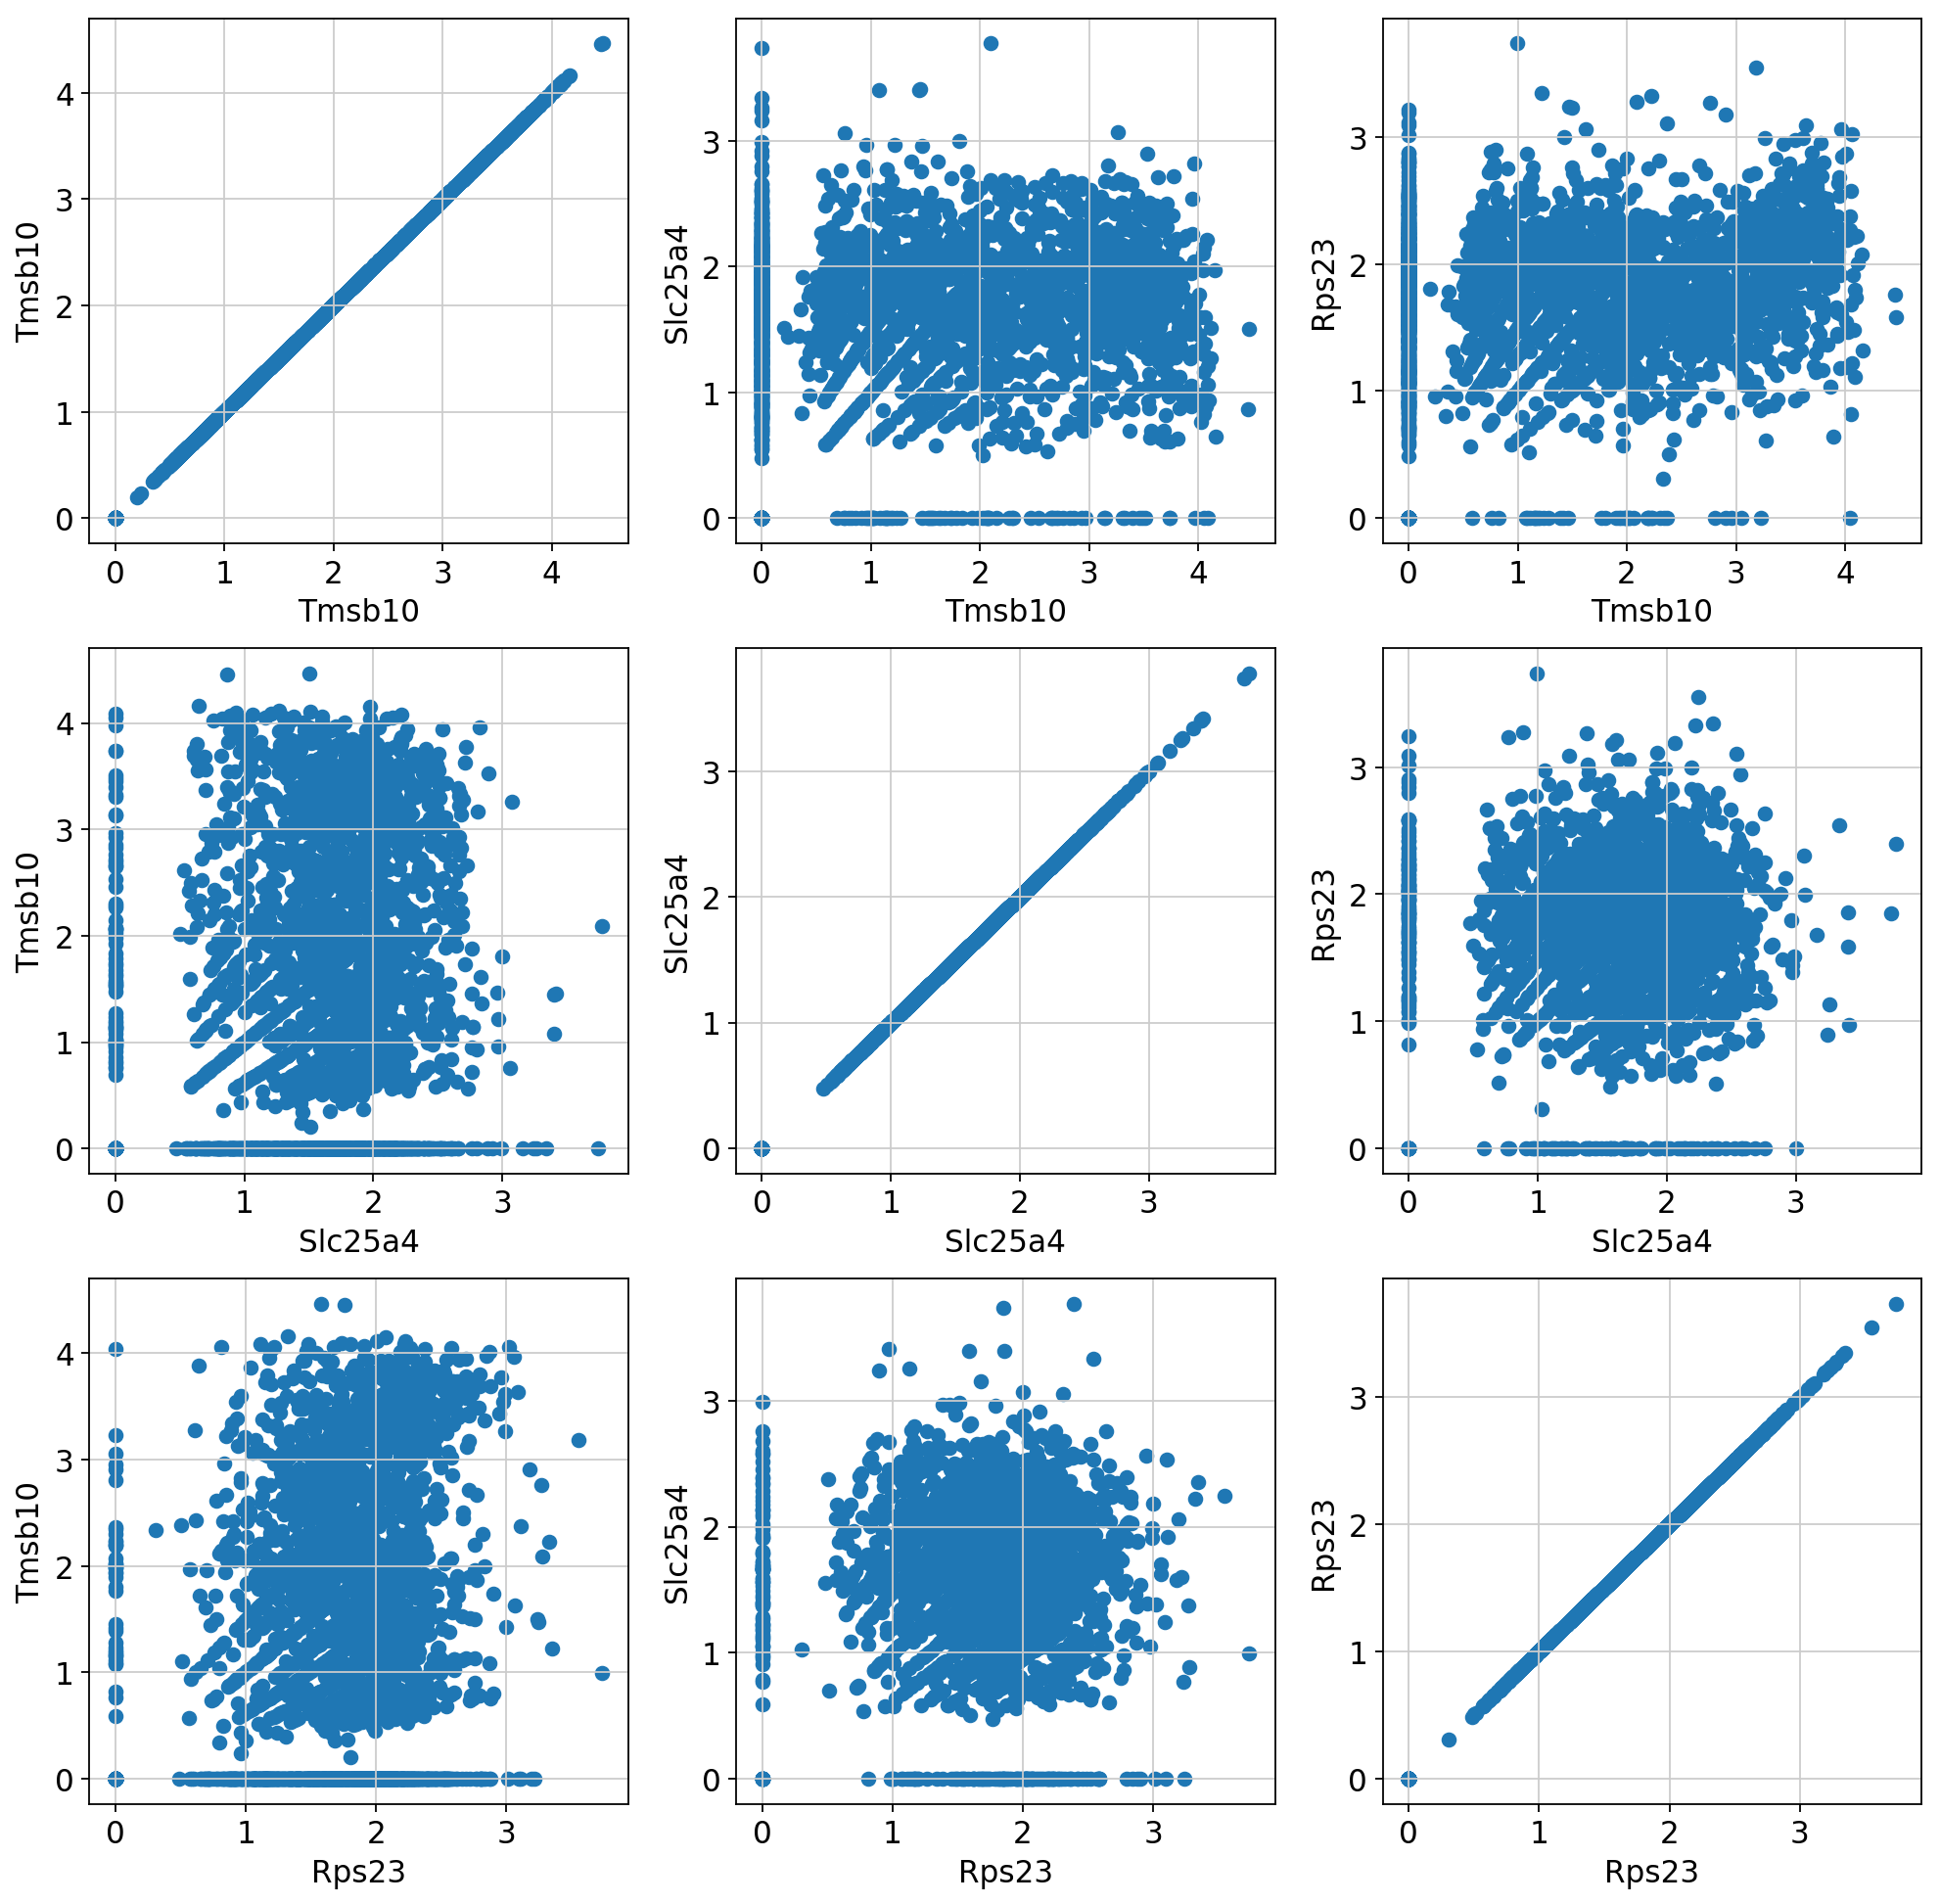

In [25]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i, genei in enumerate(last[:3]):
    for j, genej in enumerate(last[:3]):
        ax[i][j].scatter(adata.X[:, genes[genei]].A, adata.X[:, genes[genej]].A)
        ax[i][j].set_xlabel(genei)
        ax[i][j].set_ylabel(genej)

# Gaussian Process with RNA Velocity Observations

Enhance the model by adding RNA Velocities

    1. Use only 70% of the dataset as it's very sparse

In [26]:
kernel_do = RBFKernel(alpha=0.1, gamma=1)
gp_do = GP(kernel=kernel_do, derivative_observations=True, alpha=1e-4, optimize=False)

In [27]:
errors_do = []
weighted_errors_do = []

X = adata.obsm["X_umap"][:, :2]
dy_x1 = adata.obsm["velocity_umap"][:, 0]
dy_x2 = adata.obsm["velocity_umap"][:, 1]

In [28]:
# Use the same gammas as in the baseline model
gp_do.gamma = gp.kernel.gamma

In [29]:
data = adata.X.A
for gene in GENES:
    y = data[:, genes[gene]].reshape(-1)
    Y = np.hstack((y, dy_x1, dy_x2))
    gp_do.fit(X, Y.reshape(-1, 1), sample_ratio=0.7)
    gp_do.log_marginal_likelihood(gene, info=True)
    pred = gp_do.predict(X)
    errors_do.append(np.sqrt(np.mean(np.square(y - pred))))
    weighted_errors_do.append(loss(y, pred, penalize_0s=False))

Gene: Prex2        Marginal Likelihood: [-1920.19225951]
Gene: A830018L16Rik Marginal Likelihood: [-1940.59151097]
Gene: Hs6st1       Marginal Likelihood: [-1930.20981982]
Gene: Rpl31        Marginal Likelihood: [-2213.27569401]
Gene: Map4k4       Marginal Likelihood: [-1940.56598789]
Gene: Gm10561      Marginal Likelihood: [-1910.29486651]
Gene: Bzw1         Marginal Likelihood: [-1936.82652874]
Gene: Nop58        Marginal Likelihood: [-1951.08989241]
Gene: Nrp2         Marginal Likelihood: [-1966.71179117]
Gene: Unc80        Marginal Likelihood: [-2028.35482565]
Gene: Rpl37a       Marginal Likelihood: [-2482.83146027]
Gene: Arpc2        Marginal Likelihood: [-2275.97410547]
Gene: Fam134a      Marginal Likelihood: [-2010.8733405]
Gene: 2810459M11Rik Marginal Likelihood: [-1916.77408326]
Gene: Ube2f        Marginal Likelihood: [-1975.65846921]
Gene: Asb1         Marginal Likelihood: [-1912.17033777]
Gene: Fam174a      Marginal Likelihood: [-2127.47447125]
Gene: Cntnap5a     Marginal Li

Gene: Skp1a        Marginal Likelihood: [-2061.30600161]
Gene: Acsl6        Marginal Likelihood: [-1929.75153224]
Gene: Gria1        Marginal Likelihood: [-2188.4849408]
Gene: Larp1        Marginal Likelihood: [-1950.52460286]
Gene: Trpv2        Marginal Likelihood: [-1912.7845125]
Gene: Gps2         Marginal Likelihood: [-1966.06180194]
Gene: Rtn4rl1      Marginal Likelihood: [-1948.72449398]
Gene: Prpf8        Marginal Likelihood: [-1972.08881101]
Gene: Slc43a2      Marginal Likelihood: [-1953.89365246]
Gene: Myo18a       Marginal Likelihood: [-1945.11296721]
Gene: Flot2        Marginal Likelihood: [-1958.64549454]
Gene: Sept4        Marginal Likelihood: [-1946.03959838]
Gene: Mmd          Marginal Likelihood: [-2116.60963665]
Gene: Car10        Marginal Likelihood: [-1932.9587414]
Gene: Psmb3        Marginal Likelihood: [-2166.94291694]
Gene: Rapgefl1     Marginal Likelihood: [-1990.0912641]
Gene: Tubg2        Marginal Likelihood: [-1957.22938471]
Gene: Cntnap1      Marginal Likelih

Gene: Rgs7bp       Marginal Likelihood: [-2082.86482232]
Gene: Rab3c        Marginal Likelihood: [-1940.29974069]
Gene: Skiv2l2      Marginal Likelihood: [-1922.60557701]
Gene: Ptprg        Marginal Likelihood: [-1938.26402116]
Gene: Synpr        Marginal Likelihood: [-2116.34012761]
Gene: Zswim8       Marginal Likelihood: [-1941.16159888]
Gene: Adk          Marginal Likelihood: [-2006.22210973]
Gene: Rps24        Marginal Likelihood: [-2442.16801924]
Gene: Selk         Marginal Likelihood: [-2327.66525884]
Gene: Glud1        Marginal Likelihood: [-2026.74892578]
Gene: Pnp          Marginal Likelihood: [-1925.58982005]
Gene: Mrpl52       Marginal Likelihood: [-2045.72051852]
Gene: Cmtm5        Marginal Likelihood: [-1937.17633004]
Gene: Lrrc16b      Marginal Likelihood: [-1918.61779579]
Gene: Cpne6        Marginal Likelihood: [-2057.84603318]
Gene: Irf9         Marginal Likelihood: [-1914.77491655]
Gene: Mphosph8     Marginal Likelihood: [-2025.55264546]
Gene: Pinx1        Marginal Lik

Gene: Atf6b        Marginal Likelihood: [-1993.67978195]
Gene: Ddah2        Marginal Likelihood: [-1982.42479938]
Gene: Gabbr1       Marginal Likelihood: [-2098.51863568]
Gene: Ptchd4       Marginal Likelihood: [-2008.08248084]
Gene: Fsd1         Marginal Likelihood: [-1966.79341753]
Gene: Mpnd         Marginal Likelihood: [-2042.26949325]
Gene: Hdgfrp2      Marginal Likelihood: [-1993.90255841]
Gene: Rpl36        Marginal Likelihood: [-2280.85394713]
Gene: Ndufa11      Marginal Likelihood: [-2194.87956641]
Gene: Dus3l        Marginal Likelihood: [-1957.25959812]
Gene: Cntnap5c     Marginal Likelihood: [-1896.35372644]
Gene: A330050F15Rik Marginal Likelihood: [-1926.51318406]
Gene: Dlgap1       Marginal Likelihood: [-2180.41375098]
Gene: Slc30a6      Marginal Likelihood: [-1917.06250375]
Gene: Gpatch11     Marginal Likelihood: [-1937.05308629]
Gene: Ndufaf7      Marginal Likelihood: [-1982.27166927]
Gene: Eml4         Marginal Likelihood: [-1956.55430271]
Gene: Prkce        Marginal Li

Gene: Romo1        Marginal Likelihood: [-2086.43012868]
Gene: Phf20        Marginal Likelihood: [-2006.58620318]
Gene: Ralgapb      Marginal Likelihood: [-1932.70807766]
Gene: Top1         Marginal Likelihood: [-2149.58457929]
Gene: Slc12a5      Marginal Likelihood: [-2001.00127887]
Gene: Gnas         Marginal Likelihood: [-2393.34352327]
Gene: Hspa14       Marginal Likelihood: [-1956.71943886]
Gene: Cdc123       Marginal Likelihood: [-2039.21359021]
Gene: Celf2        Marginal Likelihood: [-2177.29143774]
Gene: Atp5c1       Marginal Likelihood: [-2317.20961444]
Gene: Itga8        Marginal Likelihood: [-1917.77292381]
Gene: C1ql3        Marginal Likelihood: [-2158.48864095]
Gene: Dnajc1       Marginal Likelihood: [-1938.92501226]
Gene: Spopl        Marginal Likelihood: [-1919.18131064]
Gene: Cacna1b      Marginal Likelihood: [-1934.81866891]
Gene: Qsox2        Marginal Likelihood: [-1913.65365486]
Gene: Dnlz         Marginal Likelihood: [-2067.27668245]
Gene: Fam163b      Marginal Lik

Gene: Srrm1        Marginal Likelihood: [-2033.18520872]
Gene: Cdc42        Marginal Likelihood: [-2150.49749432]
Gene: Crocc        Marginal Likelihood: [-1918.15454454]
Gene: Kcnab2       Marginal Likelihood: [-1998.54649671]
Gene: Fam213b      Marginal Likelihood: [-2004.69018463]
Gene: Agrn         Marginal Likelihood: [-1965.90054414]
Gene: Prdm8        Marginal Likelihood: [-1947.09005235]
Gene: Fgf5         Marginal Likelihood: [-1906.8745008]
Gene: D930016D06Rik Marginal Likelihood: [-1927.44065731]
Gene: Ephx4        Marginal Likelihood: [-2042.8077809]
Gene: Rpl5         Marginal Likelihood: [-2243.60799859]
Gene: Gm10419      Marginal Likelihood: [-1955.08279557]
Gene: Rpl6         Marginal Likelihood: [-2240.08142993]
Gene: Arpc3        Marginal Likelihood: [-2170.49776061]
Gene: Atp6v0a2     Marginal Likelihood: [-1904.44810055]
Gene: Gbas         Marginal Likelihood: [-1968.6424698]
Gene: Caln1        Marginal Likelihood: [-2015.28525099]
Gene: Mdh2         Marginal Likel

Gene: Mrpl23       Marginal Likelihood: [-2084.92445653]
Gene: Tfpt         Marginal Likelihood: [-1965.91315121]
Gene: Tmem238      Marginal Likelihood: [-1926.55777926]
Gene: Chmp2a       Marginal Likelihood: [-2129.72981906]
Gene: Gltscr2      Marginal Likelihood: [-2129.00175499]
Gene: Gm26802      Marginal Likelihood: [-1908.37851187]
Gene: Fosb         Marginal Likelihood: [-1913.2089946]
Gene: Clasrp       Marginal Likelihood: [-1938.74513409]
Gene: Psmc4        Marginal Likelihood: [-2070.09636957]
Gene: Eif3k        Marginal Likelihood: [-2226.80354337]
Gene: Psenen       Marginal Likelihood: [-2084.35059395]
Gene: Cox6b1       Marginal Likelihood: [-2352.92917722]
Gene: Rbm42        Marginal Likelihood: [-2000.66457032]
Gene: Mag          Marginal Likelihood: [-1924.93551484]
Gene: Fxyd1        Marginal Likelihood: [-1940.71969823]
Gene: Uri1         Marginal Likelihood: [-1970.50326197]
Gene: Fcgrt        Marginal Likelihood: [-1942.65949037]
Gene: Rps11        Marginal Like

Gene: Keap1        Marginal Likelihood: [-1975.01246907]
Gene: Dock6        Marginal Likelihood: [-1902.83065827]
Gene: Elavl3       Marginal Likelihood: [-2178.8851023]
Gene: Elof1        Marginal Likelihood: [-2076.28438493]
Gene: Rp9          Marginal Likelihood: [-2037.42538924]
Gene: Ntm          Marginal Likelihood: [-1953.83306853]
Gene: St3gal4      Marginal Likelihood: [-1922.70813261]
Gene: Ei24         Marginal Likelihood: [-2059.09868501]
Gene: Nrgn         Marginal Likelihood: [-2231.88833196]
Gene: Sorl1        Marginal Likelihood: [-2039.51976394]
Gene: Grik4        Marginal Likelihood: [-1939.22430433]
Gene: Trappc4      Marginal Likelihood: [-2107.3146495]
Gene: Pafah1b2     Marginal Likelihood: [-2040.65261073]
Gene: Zbtb16       Marginal Likelihood: [-1929.95767337]
Gene: Dlat         Marginal Likelihood: [-2000.13813595]
Gene: Elmod1       Marginal Likelihood: [-1975.05810662]
Gene: Dmxl2        Marginal Likelihood: [-1971.621469]
Gene: Etfa         Marginal Likelih

In [30]:
lh_do = gp.get_all_likelihoods()
top_do = list(zip(*sorted(list(lh_do.items()), key=lambda x:x[1], reverse=True)))[0]
last_do = top_do[::-1]
top_do[:10]

('Cntnap5c',
 'Gm11508',
 'Zfp931',
 'Atp6ap1',
 'Pm20d2',
 'A430105J06Rik',
 '4930426I24Rik',
 'Frmd3',
 'Tgfbr2',
 'Ccdc93')

In [31]:
last_do[:10]

('Tmsb10',
 'Slc25a4',
 'Rps23',
 'Rpl17',
 'Rpl37a',
 'Rpl37',
 'Rps27',
 'Rps16',
 'Rps24',
 'Rps11')

# Gaussian Process with RBF + Linear Kernel

    1. Use 70% of the data as it's very sparse

Check how RBF + Linear Kernel compares to the one with RNA Velocity observations

In [32]:
kernel_combined = RBFKernel(alpha=0.1, gamma=1) + LinearKernel(scale=0.1, sigma=0.0)
gp_combined = GP(kernel=kernel_combined, alpha=1e-3, optimize=False)

In [33]:
errors_combined = []
weighted_errors_combined = []

X = adata.obsm["X_umap"][:, :2]

In [34]:
## Use optimized gama from Baseline Model
gp_combined.kernel.gamma = gp.kernel.gamma

In [35]:
#### Fit On All Genes
data = adata.X.A
for gene in GENES:
    y = data[:, genes[gene]].reshape(-1)
    Y = y
    gp_combined.fit(X, Y.reshape(-1, 1), sample_ratio=0.7)
    gp_combined.log_marginal_likelihood(gene, info=True)
    pred = gp_combined.predict(X)
    errors_combined.append(np.sqrt(np.sum((y - pred)**2)/X.shape[0]))
    weighted_errors_combined.append(loss(y, pred, penalize_0s=False))

Gene: Prex2        Marginal Likelihood: [-3766.56911807]
Gene: A830018L16Rik Marginal Likelihood: [-3783.65327081]
Gene: Hs6st1       Marginal Likelihood: [-3772.24414736]
Gene: Rpl31        Marginal Likelihood: [-4054.02205905]
Gene: Map4k4       Marginal Likelihood: [-3786.25714874]
Gene: Gm10561      Marginal Likelihood: [-3751.71679622]
Gene: Bzw1         Marginal Likelihood: [-3781.69566864]
Gene: Nop58        Marginal Likelihood: [-3794.59764775]
Gene: Nrp2         Marginal Likelihood: [-3813.59511459]
Gene: Unc80        Marginal Likelihood: [-3870.8345851]
Gene: Rpl37a       Marginal Likelihood: [-4311.38043316]
Gene: Arpc2        Marginal Likelihood: [-4105.69215364]
Gene: Fam134a      Marginal Likelihood: [-3853.61053052]
Gene: 2810459M11Rik Marginal Likelihood: [-3757.46423529]
Gene: Ube2f        Marginal Likelihood: [-3816.28191205]
Gene: Asb1         Marginal Likelihood: [-3756.06634474]
Gene: Fam174a      Marginal Likelihood: [-3978.25941083]
Gene: Cntnap5a     Marginal Li

Gene: Sar1b        Marginal Likelihood: [-3938.83352906]
Gene: Skp1a        Marginal Likelihood: [-3904.46413271]
Gene: Acsl6        Marginal Likelihood: [-3777.25145102]
Gene: Gria1        Marginal Likelihood: [-4010.94655165]
Gene: Larp1        Marginal Likelihood: [-3796.94610064]
Gene: Trpv2        Marginal Likelihood: [-3757.15314479]
Gene: Gps2         Marginal Likelihood: [-3811.52666857]
Gene: Rtn4rl1      Marginal Likelihood: [-3793.37773861]
Gene: Prpf8        Marginal Likelihood: [-3812.75986612]
Gene: Slc43a2      Marginal Likelihood: [-3798.2616709]
Gene: Myo18a       Marginal Likelihood: [-3787.36667771]
Gene: Flot2        Marginal Likelihood: [-3804.78946955]
Gene: Sept4        Marginal Likelihood: [-3790.78056096]
Gene: Mmd          Marginal Likelihood: [-3962.45990446]
Gene: Car10        Marginal Likelihood: [-3781.24903892]
Gene: Psmb3        Marginal Likelihood: [-4019.96285194]
Gene: Rapgefl1     Marginal Likelihood: [-3833.29305467]
Gene: Tubg2        Marginal Like

Gene: Pik3r1       Marginal Likelihood: [-3830.42018816]
Gene: Rgs7bp       Marginal Likelihood: [-3925.94758646]
Gene: Rab3c        Marginal Likelihood: [-3785.7876181]
Gene: Skiv2l2      Marginal Likelihood: [-3768.31362586]
Gene: Ptprg        Marginal Likelihood: [-3782.38820159]
Gene: Synpr        Marginal Likelihood: [-3945.53129686]
Gene: Zswim8       Marginal Likelihood: [-3781.37753015]
Gene: Adk          Marginal Likelihood: [-3848.70140106]
Gene: Rps24        Marginal Likelihood: [-4282.6173508]
Gene: Selk         Marginal Likelihood: [-4150.25174073]
Gene: Glud1        Marginal Likelihood: [-3867.7889822]
Gene: Pnp          Marginal Likelihood: [-3770.16676241]
Gene: Mrpl52       Marginal Likelihood: [-3888.12067189]
Gene: Cmtm5        Marginal Likelihood: [-3784.07139226]
Gene: Lrrc16b      Marginal Likelihood: [-3758.41468884]
Gene: Cpne6        Marginal Likelihood: [-3896.64831009]
Gene: Irf9         Marginal Likelihood: [-3760.48049486]
Gene: Mphosph8     Marginal Likeli

Gene: Zfp414       Marginal Likelihood: [-3811.62250898]
Gene: Atf6b        Marginal Likelihood: [-3845.93571014]
Gene: Ddah2        Marginal Likelihood: [-3820.00528338]
Gene: Gabbr1       Marginal Likelihood: [-3950.85327795]
Gene: Ptchd4       Marginal Likelihood: [-3844.6167574]
Gene: Fsd1         Marginal Likelihood: [-3815.056358]
Gene: Mpnd         Marginal Likelihood: [-3881.43954152]
Gene: Hdgfrp2      Marginal Likelihood: [-3835.43349481]
Gene: Rpl36        Marginal Likelihood: [-4119.88484996]
Gene: Ndufa11      Marginal Likelihood: [-4046.16901658]
Gene: Dus3l        Marginal Likelihood: [-3801.75714104]
Gene: Cntnap5c     Marginal Likelihood: [-3741.32293362]
Gene: A330050F15Rik Marginal Likelihood: [-3772.67624833]
Gene: Dlgap1       Marginal Likelihood: [-4015.91146825]
Gene: Slc30a6      Marginal Likelihood: [-3763.63291378]
Gene: Gpatch11     Marginal Likelihood: [-3787.07874988]
Gene: Ndufaf7      Marginal Likelihood: [-3824.64721365]
Gene: Eml4         Marginal Likel

Gene: Mapre1       Marginal Likelihood: [-3929.82617574]
Gene: Romo1        Marginal Likelihood: [-3933.54176117]
Gene: Phf20        Marginal Likelihood: [-3852.45256162]
Gene: Ralgapb      Marginal Likelihood: [-3774.50757711]
Gene: Top1         Marginal Likelihood: [-3995.84481092]
Gene: Slc12a5      Marginal Likelihood: [-3840.01580031]
Gene: Gnas         Marginal Likelihood: [-4219.60450161]
Gene: Hspa14       Marginal Likelihood: [-3803.16999343]
Gene: Cdc123       Marginal Likelihood: [-3889.08734661]
Gene: Celf2        Marginal Likelihood: [-4027.39760471]
Gene: Atp5c1       Marginal Likelihood: [-4167.39333107]
Gene: Itga8        Marginal Likelihood: [-3763.0891368]
Gene: C1ql3        Marginal Likelihood: [-3987.66222275]
Gene: Dnajc1       Marginal Likelihood: [-3779.68451836]
Gene: Spopl        Marginal Likelihood: [-3764.59823453]
Gene: Cacna1b      Marginal Likelihood: [-3780.48999925]
Gene: Qsox2        Marginal Likelihood: [-3760.5567123]
Gene: Dnlz         Marginal Likel

Gene: Srrm1        Marginal Likelihood: [-3882.03848464]
Gene: Cdc42        Marginal Likelihood: [-3988.07512238]
Gene: Crocc        Marginal Likelihood: [-3761.83207738]
Gene: Kcnab2       Marginal Likelihood: [-3843.89860084]
Gene: Fam213b      Marginal Likelihood: [-3843.97070037]
Gene: Agrn         Marginal Likelihood: [-3808.55633996]
Gene: Prdm8        Marginal Likelihood: [-3797.46126964]
Gene: Fgf5         Marginal Likelihood: [-3749.85543791]
Gene: D930016D06Rik Marginal Likelihood: [-3773.59367112]
Gene: Ephx4        Marginal Likelihood: [-3887.23344052]
Gene: Rpl5         Marginal Likelihood: [-4084.85575127]
Gene: Gm10419      Marginal Likelihood: [-3798.59103063]
Gene: Rpl6         Marginal Likelihood: [-4082.82393662]
Gene: Arpc3        Marginal Likelihood: [-4006.25706503]
Gene: Atp6v0a2     Marginal Likelihood: [-3747.33650196]
Gene: Gbas         Marginal Likelihood: [-3810.73087927]
Gene: Caln1        Marginal Likelihood: [-3858.74936013]
Gene: Mdh2         Marginal Li

Gene: Tfpt         Marginal Likelihood: [-3809.09136071]
Gene: Tmem238      Marginal Likelihood: [-3767.72649634]
Gene: Chmp2a       Marginal Likelihood: [-3975.76379461]
Gene: Gltscr2      Marginal Likelihood: [-3970.63843243]
Gene: Gm26802      Marginal Likelihood: [-3752.62714399]
Gene: Fosb         Marginal Likelihood: [-3757.42787936]
Gene: Clasrp       Marginal Likelihood: [-3790.34386027]
Gene: Psmc4        Marginal Likelihood: [-3918.1208833]
Gene: Eif3k        Marginal Likelihood: [-4057.23999841]
Gene: Psenen       Marginal Likelihood: [-3927.85700626]
Gene: Cox6b1       Marginal Likelihood: [-4198.89638329]
Gene: Rbm42        Marginal Likelihood: [-3838.37478343]
Gene: Mag          Marginal Likelihood: [-3764.84123741]
Gene: Fxyd1        Marginal Likelihood: [-3783.60726812]
Gene: Uri1         Marginal Likelihood: [-3816.25108386]
Gene: Fcgrt        Marginal Likelihood: [-3782.69890037]
Gene: Rps11        Marginal Likelihood: [-4285.45580784]
Gene: Lin7b        Marginal Like

Gene: Keap1        Marginal Likelihood: [-3824.60799118]
Gene: Dock6        Marginal Likelihood: [-3747.57784882]
Gene: Elavl3       Marginal Likelihood: [-4021.26990587]
Gene: Elof1        Marginal Likelihood: [-3915.37132946]
Gene: Rp9          Marginal Likelihood: [-3886.68443633]
Gene: Ntm          Marginal Likelihood: [-3797.47079359]
Gene: St3gal4      Marginal Likelihood: [-3768.47235346]
Gene: Ei24         Marginal Likelihood: [-3903.85068743]
Gene: Nrgn         Marginal Likelihood: [-4056.11841364]
Gene: Sorl1        Marginal Likelihood: [-3887.47899905]
Gene: Grik4        Marginal Likelihood: [-3787.02801459]
Gene: Trappc4      Marginal Likelihood: [-3950.47975467]
Gene: Pafah1b2     Marginal Likelihood: [-3894.61009548]
Gene: Zbtb16       Marginal Likelihood: [-3774.61932203]
Gene: Dlat         Marginal Likelihood: [-3846.4837275]
Gene: Elmod1       Marginal Likelihood: [-3820.03343341]
Gene: Dmxl2        Marginal Likelihood: [-3812.21390701]
Gene: Etfa         Marginal Like

In [36]:
lh_combined = gp_combined.get_all_likelihoods()
top_combined = list(zip(*sorted(list(lh_combined.items()), key=lambda x:x[1], reverse=True)))[0]
last_combined = top_combined[::-1]
top_combined[:10]

('Zfp931',
 'Cntnap5c',
 'Gm11508',
 'Pm20d2',
 'Atp6ap1',
 'Frmd3',
 'Dnah8',
 'Rbms3',
 '4930426I24Rik',
 'Gm12089')

In [37]:
last_combined[:10]

('Tmsb10',
 'Slc25a4',
 'Rps23',
 'Rpl17',
 'Rpl37a',
 'Rpl37',
 'Rps11',
 'Rps27',
 'Rps24',
 'Rps16')

## Look at Smoothest and Least Smoth Genes

All three models agree on some the smoothest genes so let's inspect them

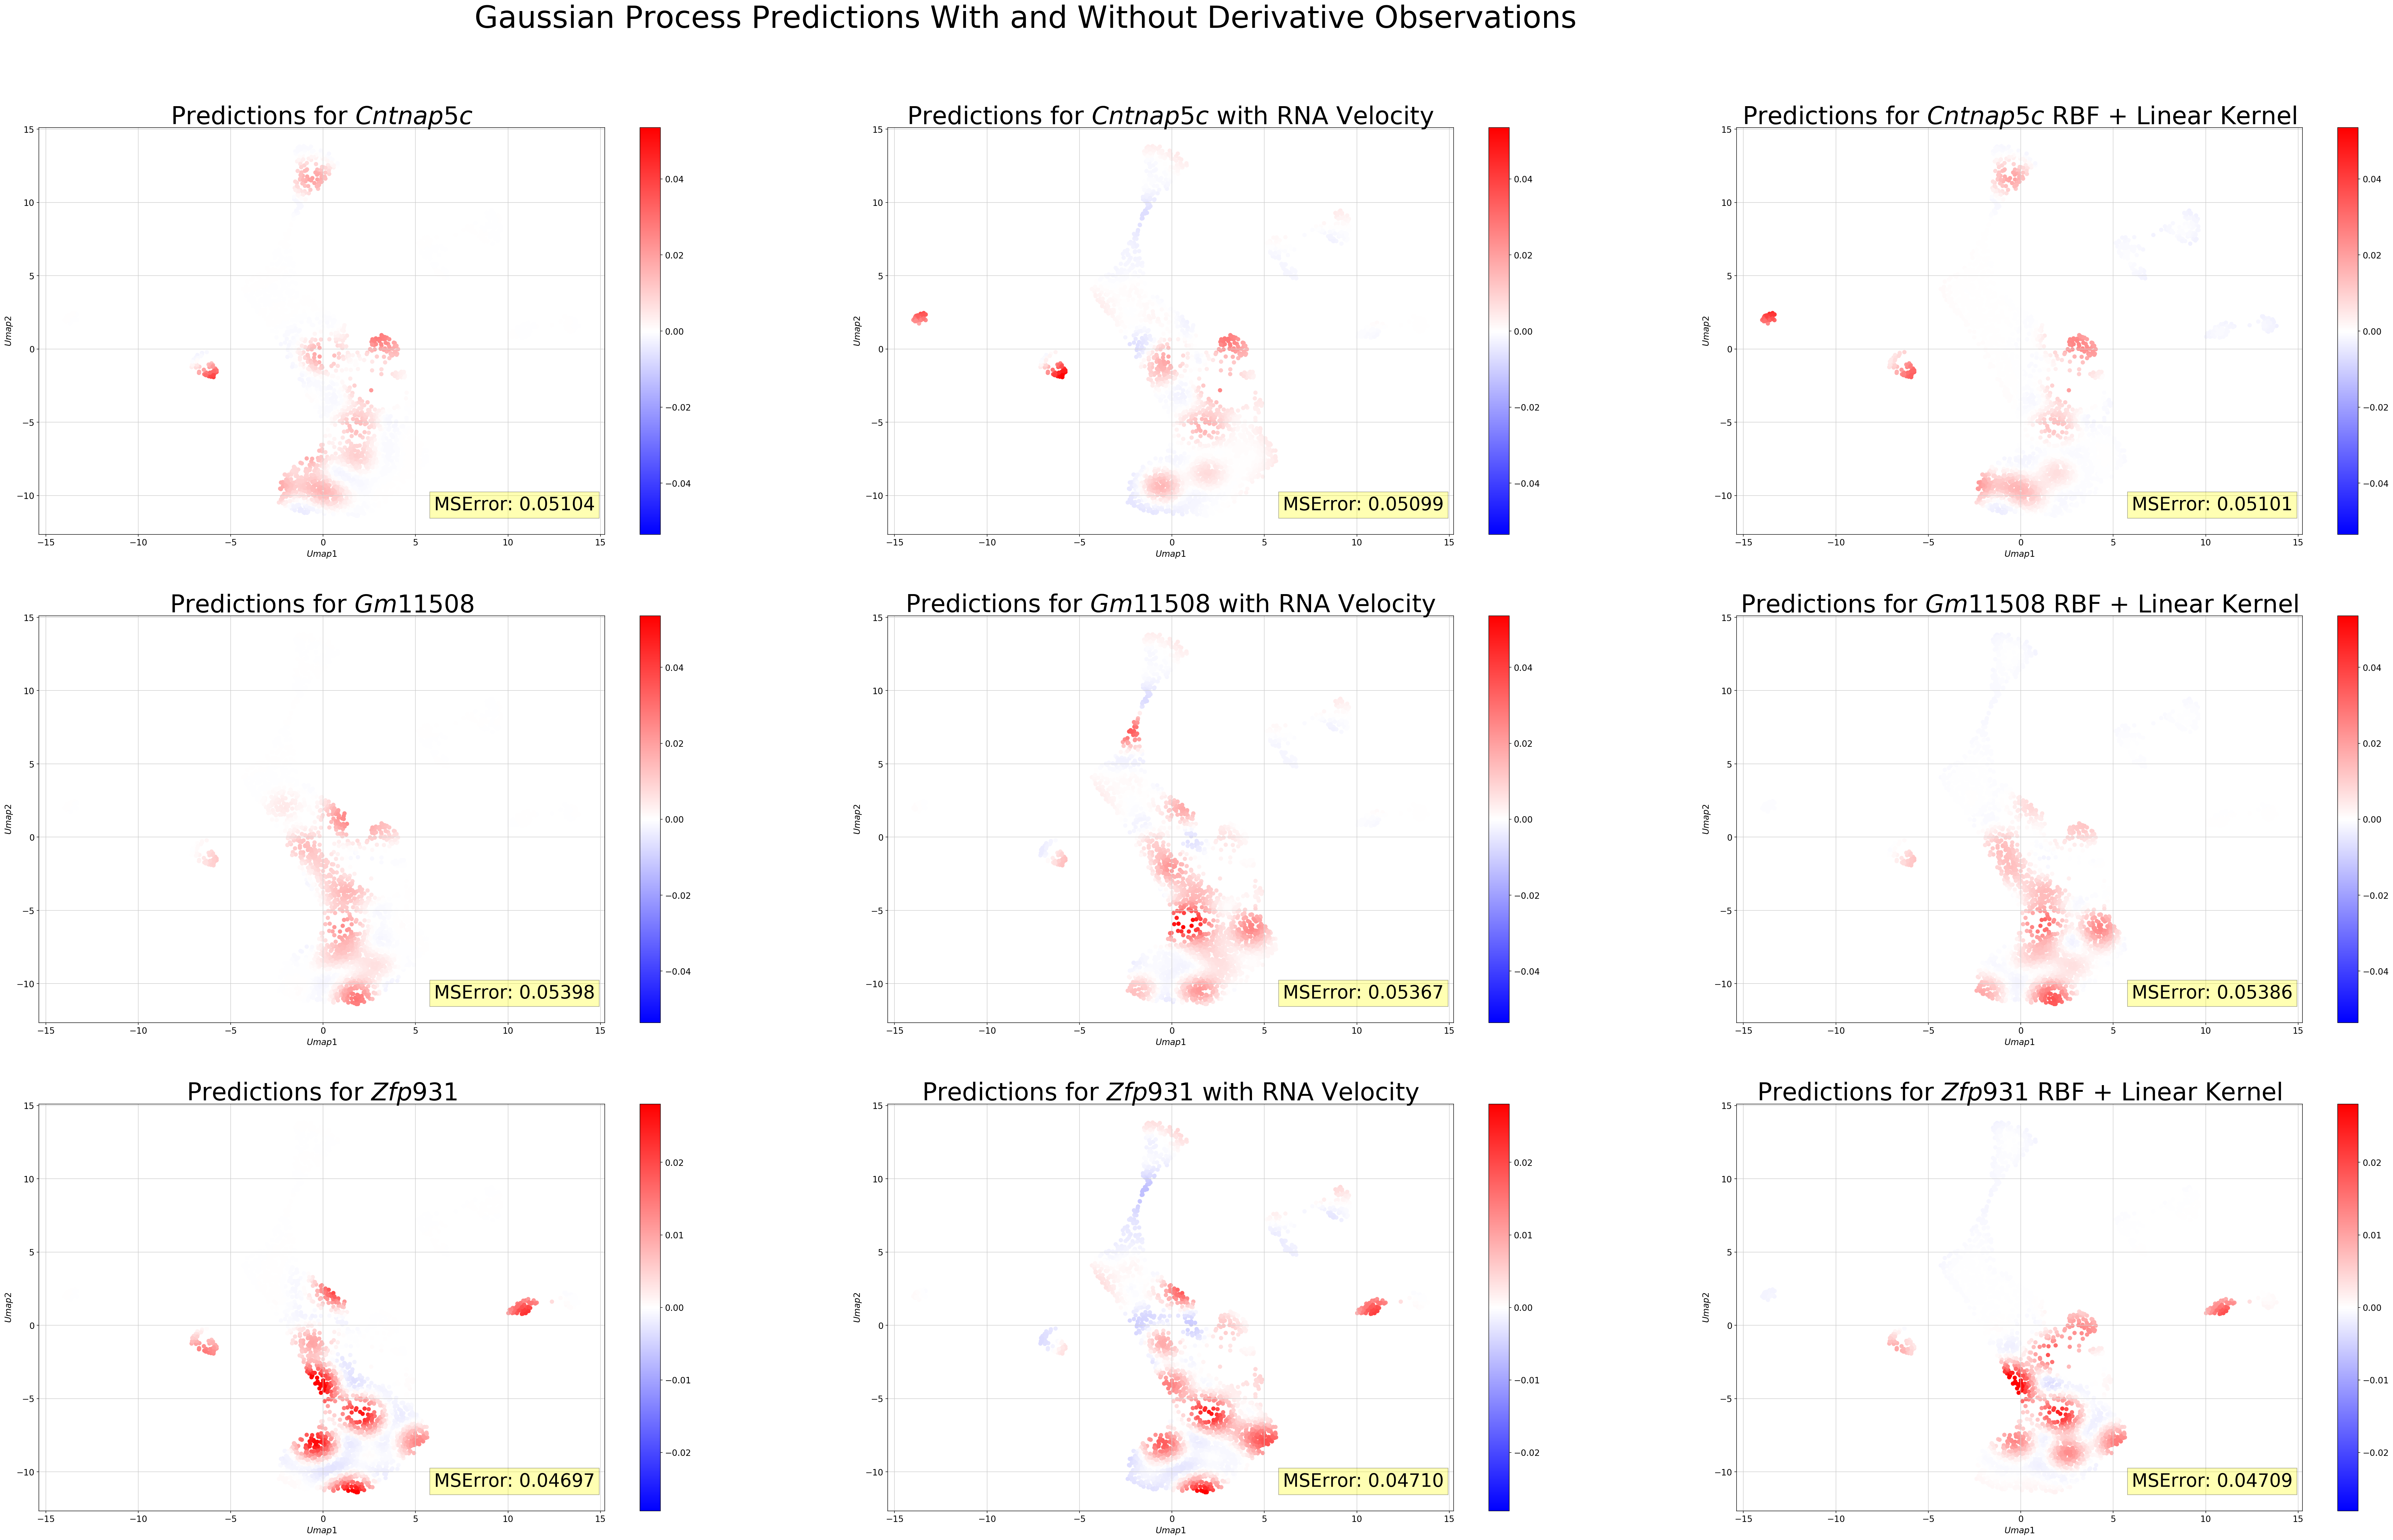

In [38]:
%matplotlib inline
fig, axs = plt.subplots(3, 3, figsize=(70,40))
dy_x1 = adata.obsm["velocity_umap"][:, 0] 
dy_x2 = adata.obsm["velocity_umap"][:, 1] 
X = adata.obsm["X_umap"][:, :2]
 
for i, gene in enumerate(top[:3]):

    y = adata.X[:, genes[gene]].A.reshape(-1)
    gp.fit(X, y.reshape(-1, 1), sample_ratio=.7)
    pred = gp.predict(X)
    gp_error = loss(y, pred.reshape(-1), penalize_0s=True)
    
    Y = np.hstack((y.reshape(-1), dy_x1, dy_x2))
    gp_do.fit(X, Y.reshape(-1, 1), sample_ratio=.7)
    pred_do = gp_do.predict(X)
    gp_do_error = loss(y, pred_do.reshape(-1), penalize_0s=True)

    gp_combined.fit(X, y.reshape(-1, 1), sample_ratio=.7)
    pred_combined = gp_combined.predict(X)
    gp_combined_error = loss(y, pred_combined.reshape(-1), penalize_0s=True)
    
    _min, _max = -max(pred_do), max(pred_do)

    p = axs[i][0].scatter(X[:, 0], X[:, 1],  c=pred.reshape(-1), vmin=_min, vmax=_max, cmap='bwr')
    axs[i][0].text(6, -11, 'MSError: {:.5f}'.format(gp_error),
        bbox={'facecolor': 'yellow', 'alpha': 0.3, 'pad': 7}, fontsize=30)
    axs[i][0].set_xlabel('$Umap1$')
    axs[i][0].set_ylabel('$Umap2$')
    axs[i][0].set_title("Predictions for ${gene}$".format(gene=gene), fontsize=40)
    fig.colorbar(p, ax=axs[i][0])

    p = axs[i][1].scatter(X[:, 0], X[:, 1],  c=pred_do.reshape(-1), vmin=_min, vmax=_max, cmap='bwr')
    axs[i][1].text(6, -11, 'MSError: {:.5f}'.format(gp_do_error),
        bbox={'facecolor': 'yellow', 'alpha': 0.3, 'pad': 7}, fontsize=30)
    axs[i][1].set_xlabel('$Umap1$')
    axs[i][1].set_ylabel('$Umap2$')
    axs[i][1].set_title("Predictions for ${gene}$ with RNA Velocity".format(gene=gene), fontsize=40)
    fig.colorbar(p, ax=axs[i][1])
    

    p = axs[i][2].scatter(X[:, 0], X[:, 1],  c=pred_combined.reshape(-1), vmin=_min, vmax=_max, cmap='bwr')
    axs[i][2].text(6, -11, 'MSError: {:.5f}'.format(gp_combined_error),
        bbox={'facecolor': 'yellow', 'alpha': 0.3, 'pad': 7}, fontsize=30)
    axs[i][2].set_xlabel('$Umap1$')
    axs[i][2].set_ylabel('$Umap2$')
    axs[i][2].set_title("Predictions for ${gene}$ RBF + Linear Kernel".format(gene=gene), fontsize=40)
    fig.colorbar(p, ax=axs[i][2])
    
#     scv.pl.velocity_embedding_grid(adata, density = 0.4, basis='X_umap', color=gene, color_map="Blues",
#                                    size=300, alpha=0.3, arrow_length=3, arrow_size=2.3, colorbar=True,
#                                    show=False, ax=axs[i][3],
#                                    title="Actual values for ${gene}$ with RNA Velocity".format(gene=gene),
#                                    fontsize=20)
    
fig.suptitle("Gaussian Process Predictions With and Without Derivative Observations",  fontsize=50)   
fig.savefig("dentate_gyrus_top_3_smoothest_genes_3_models.png", transparent=False)

In [39]:
for gene in top[:10]:
    print("Gene found in {} cells".format(np.sum(data[:, genes[gene]]!=0)))

Gene found in 27 cells
Gene found in 26 cells
Gene found in 20 cells
Gene found in 22 cells
Gene found in 25 cells
Gene found in 34 cells
Gene found in 27 cells
Gene found in 43 cells
Gene found in 39 cells
Gene found in 40 cells


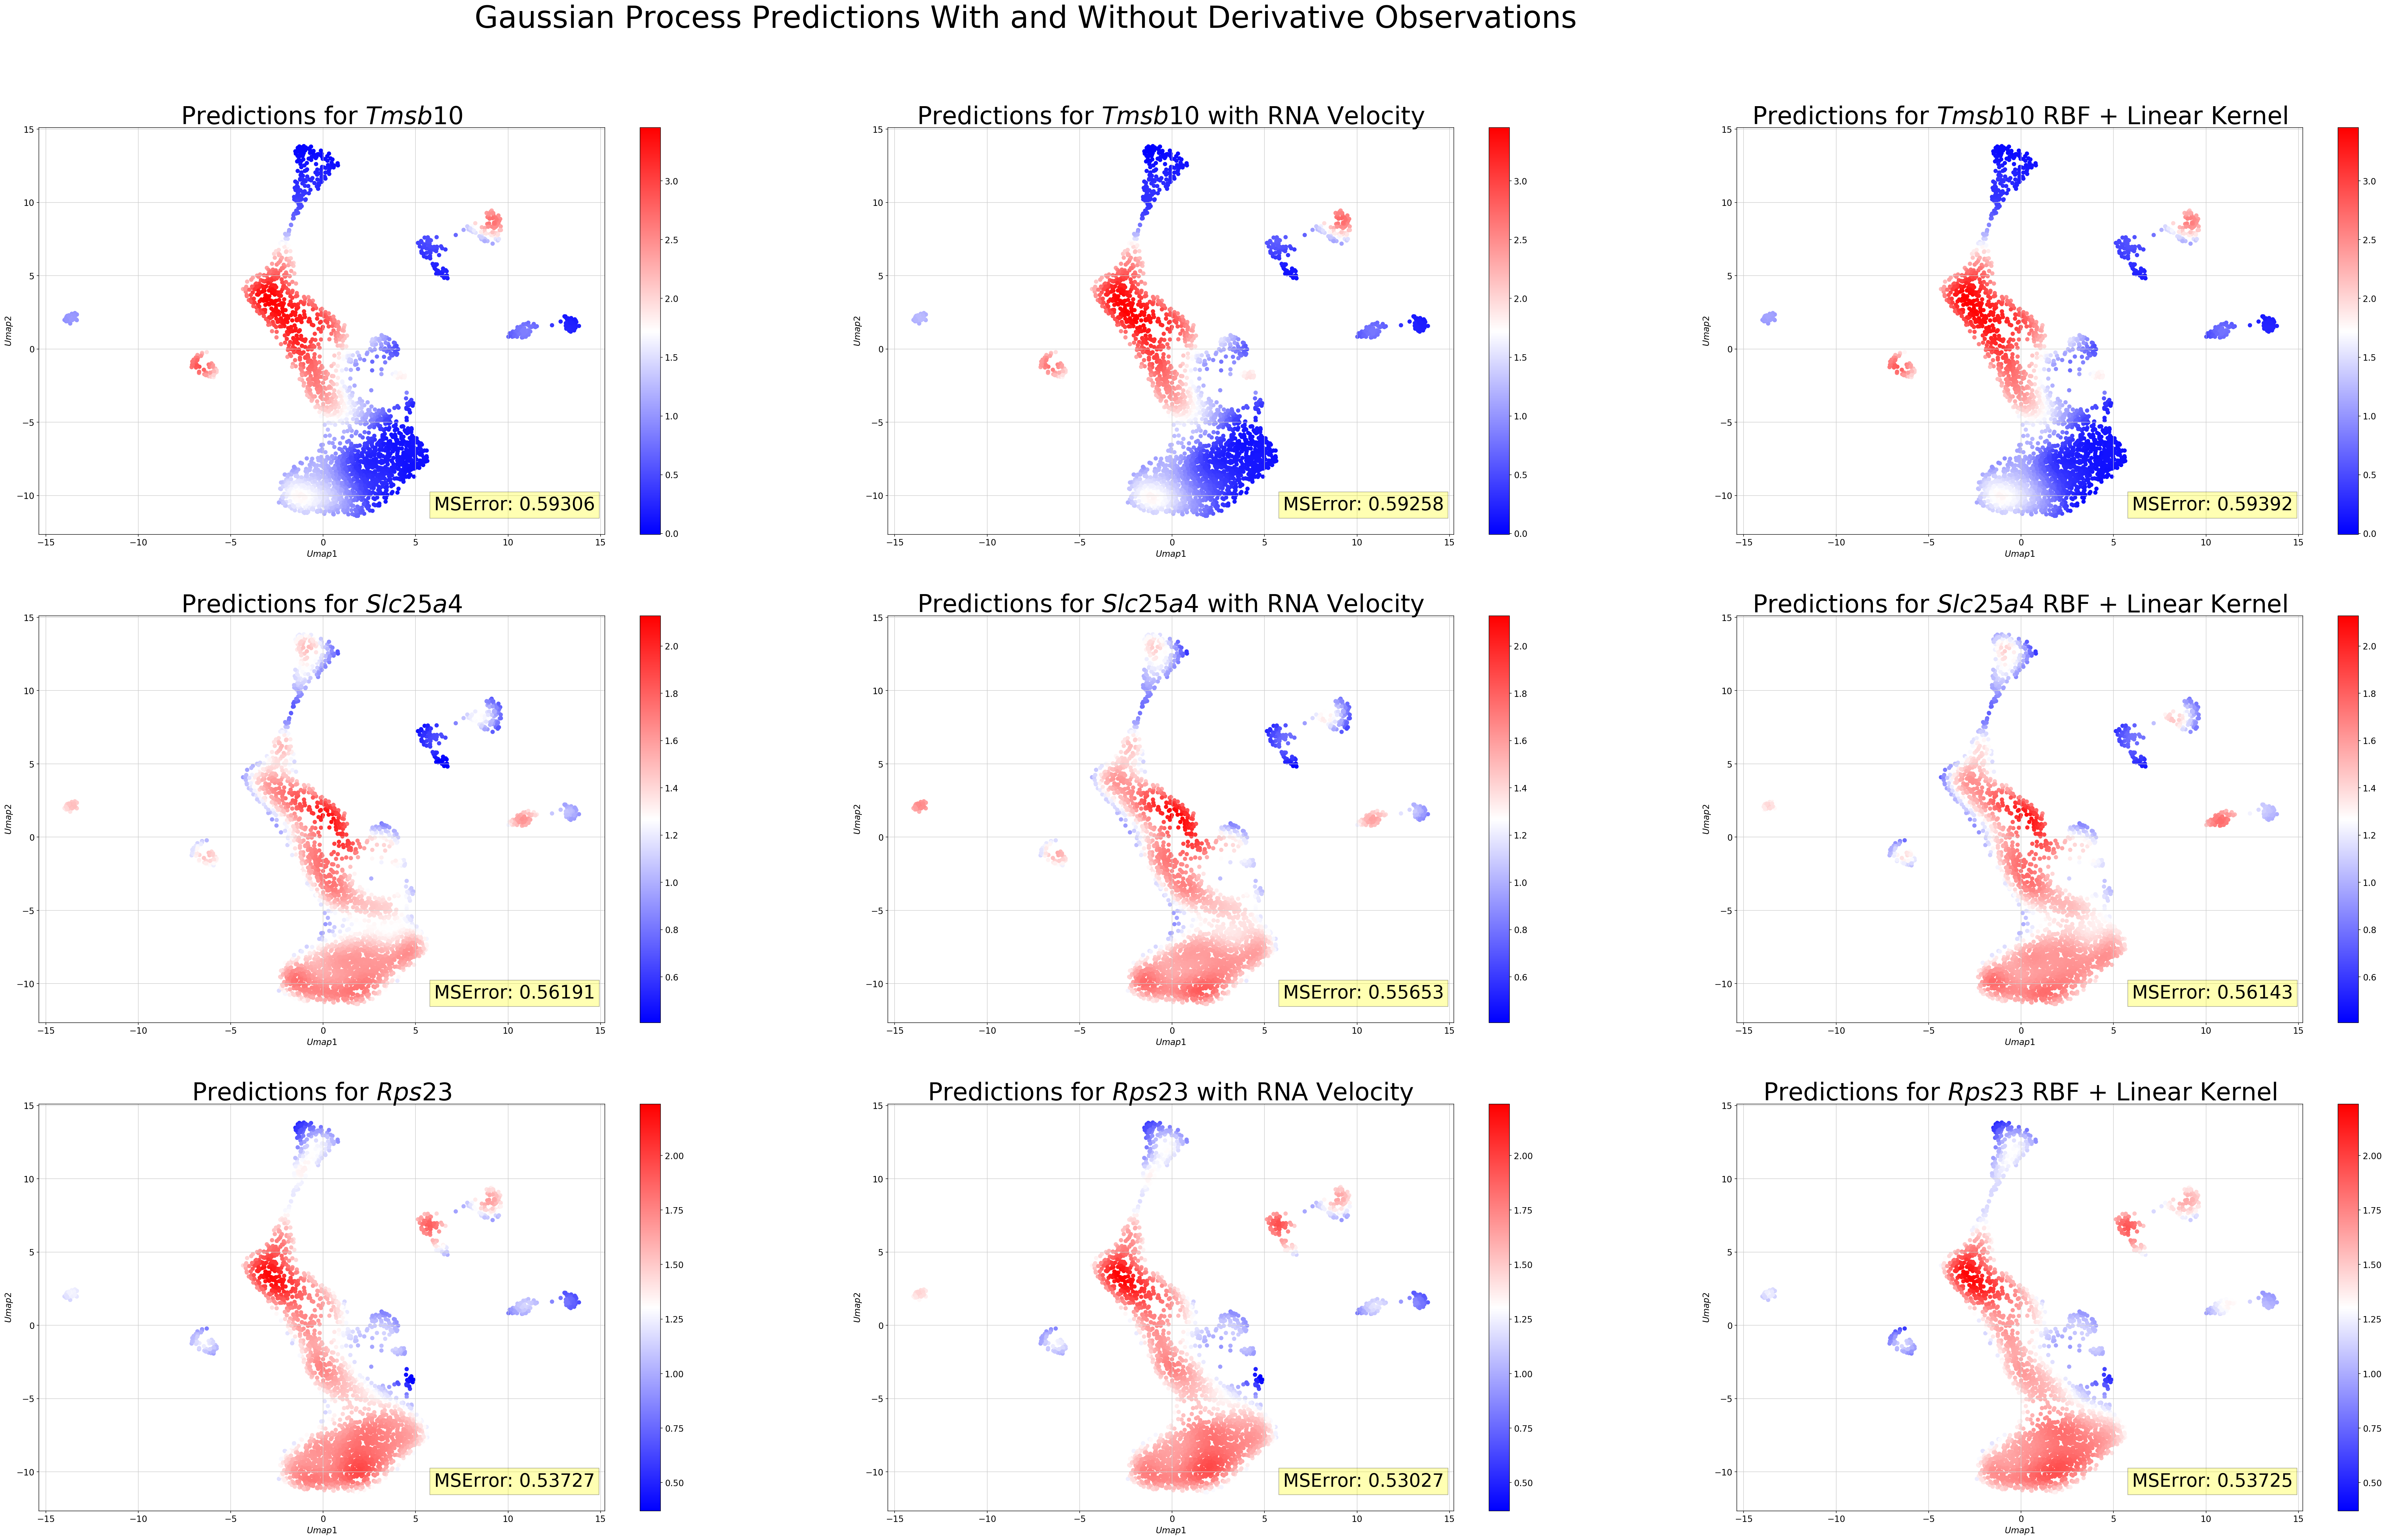

In [40]:
%matplotlib inline
fig, axs = plt.subplots(3, 3, figsize=(70,40))
dy_x1 = adata.obsm["velocity_umap"][:, 0] 
dy_x2 = adata.obsm["velocity_umap"][:, 1] 
X = adata.obsm["X_umap"][:, :2]
 
for i, gene in enumerate(last[:3]):

    y = adata.X[:, genes[gene]].A.reshape(-1)
    gp.fit(X, y.reshape(-1, 1), sample_ratio=.7)
    pred = gp.predict(X)
    gp_error = loss(y, pred.reshape(-1), penalize_0s=True)
    
    Y = np.hstack((y.reshape(-1), dy_x1, dy_x2))
    gp_do.fit(X, Y.reshape(-1, 1), sample_ratio=.7)
    pred_do = gp_do.predict(X)
    gp_do_error = loss(y, pred_do.reshape(-1), penalize_0s=True)

    gp_combined.fit(X, y.reshape(-1, 1), sample_ratio=.7)
    pred_combined = gp_combined.predict(X)
    gp_combined_error = loss(y, pred_combined.reshape(-1), penalize_0s=True)
    
    _min, _max = min(pred_do), max(pred_do)

    p = axs[i][0].scatter(X[:, 0], X[:, 1],  c=pred.reshape(-1), vmin=_min, vmax=_max, cmap='bwr')
    axs[i][0].text(6, -11, 'MSError: {:.5f}'.format(gp_error),
        bbox={'facecolor': 'yellow', 'alpha': 0.3, 'pad': 7}, fontsize=30)
    axs[i][0].set_xlabel('$Umap1$')
    axs[i][0].set_ylabel('$Umap2$')
    axs[i][0].set_title("Predictions for ${gene}$".format(gene=gene), fontsize=40)
    fig.colorbar(p, ax=axs[i][0])

    p = axs[i][1].scatter(X[:, 0], X[:, 1],  c=pred_do.reshape(-1), vmin=_min, vmax=_max, cmap='bwr')
    axs[i][1].text(6, -11, 'MSError: {:.5f}'.format(gp_do_error),
        bbox={'facecolor': 'yellow', 'alpha': 0.3, 'pad': 7}, fontsize=30)
    axs[i][1].set_xlabel('$Umap1$')
    axs[i][1].set_ylabel('$Umap2$')
    axs[i][1].set_title("Predictions for ${gene}$ with RNA Velocity".format(gene=gene), fontsize=40)
    fig.colorbar(p, ax=axs[i][1])
    

    p = axs[i][2].scatter(X[:, 0], X[:, 1],  c=pred_combined.reshape(-1), vmin=_min, vmax=_max, cmap='bwr')
    axs[i][2].text(6, -11, 'MSError: {:.5f}'.format(gp_combined_error),
        bbox={'facecolor': 'yellow', 'alpha': 0.3, 'pad': 7}, fontsize=30)
    axs[i][2].set_xlabel('$Umap1$')
    axs[i][2].set_ylabel('$Umap2$')
    axs[i][2].set_title("Predictions for ${gene}$ RBF + Linear Kernel".format(gene=gene), fontsize=40)
    fig.colorbar(p, ax=axs[i][2])
    
#     scv.pl.velocity_embedding_grid(adata, density = 0.4, basis='X_umap', color=gene, color_map="Blues",
#                                    size=300, alpha=0.3, arrow_length=3, arrow_size=2.3, colorbar=True,
#                                    show=False, ax=axs[i][3],
#                                    title="Actual values for ${gene}$ with RNA Velocity".format(gene=gene),
#                                    fontsize=20)
    
fig.suptitle("Gaussian Process Predictions With and Without Derivative Observations",  fontsize=50)   
fig.savefig("dentate_gyrus_top_3_least_smooth_genes_3_models.png", transparent=False)

In [41]:
for gene in last[:10]:
    print("Gene found in {} cells".format(np.sum(data[:, genes[gene]]!=0)))

Gene found in 2096 cells
Gene found in 2803 cells
Gene found in 2837 cells
Gene found in 2796 cells
Gene found in 2804 cells
Gene found in 2808 cells
Gene found in 2743 cells
Gene found in 2758 cells
Gene found in 2716 cells
Gene found in 2702 cells


# Analyse Genes Rankings For Each Model

In [42]:
genes = {key:idx for idx, key in enumerate(list(zip(*sorted(list(lh.items()), key=lambda x:x[1], reverse=True)))[0][:50])}
genes_do = {key:idx for idx, key in enumerate(list(zip(*sorted(list(lh_do.items()), key=lambda x:x[1], reverse=True)))[0])}
genes_combined = {key:idx for idx, key in enumerate(list(zip(*sorted(list(lh_combined.items()), key=lambda x:x[1], reverse=True)))[0])}

In [43]:
pos = {}
for key in genes.keys():
    pos[key] = genes_do[key] - genes[key]
    
print("GP vs GP + RNA Velocity".center(100))
print()
print("*********************************************************************************************".center(100))
print()
print("------------------------------------  UP  ------------------------------------\n\n", [gene for gene, p in pos.items() if p > 0])
print()
print("------------------------------------  DOWN  ------------------------------------\n\n", [gene for gene, p in pos.items() if p < 0])
print()
print("------------------------------------ UNCGANGED  ------------------------------------\n\n", [gene for gene, p in pos.items() if p == 0])

                                      GP vs GP + RNA Velocity                                       

   *********************************************************************************************    

------------------------------------  UP  ------------------------------------

 []

------------------------------------  DOWN  ------------------------------------

 []

------------------------------------ UNCGANGED  ------------------------------------

 ['Cntnap5c', 'Gm11508', 'Zfp931', 'Atp6ap1', 'Pm20d2', 'A430105J06Rik', '4930426I24Rik', 'Frmd3', 'Tgfbr2', 'Ccdc93', 'Gm4890', 'Ticam1', 'Myo16', 'Icam1', 'Galntl6', 'Gm12089', 'Hmha1', 'Dnah8', 'Ccdc127', 'Col11a1', '3110052M02Rik', 'Rbms3', 'Ankrd55', 'Nup160', 'Moxd1', 'Lpl', '2210404O09Rik', 'Fam71e1', 'Fbxo16', 'Dock6', 'Grid2', 'Ndst4', 'Erbb4', 'Fbxo30', 'Dlc1', 'Ccdc65', 'Shank1', 'Pik3c2b', 'Ncapd2', 'Gm26910', 'Ldlr', 'Rbms2', 'Setd4', 'Atp6v0a2', 'Rassf3', 'Neto2', 'Atat1', 'Gm10561', 'Fn1', 'Bcas1']


In [44]:
pos = {}
for key in genes.keys():
    pos[key] = genes_combined[key] - genes[key] 
    
print("GP vs GP + Combined Kernel".center(100))
print()
print("*********************************************************************************************".center(100))
print()
print("------------------------------------  UP  ------------------------------------\n\n", [(gene, p) for gene, p in pos.items() if p > 0])
print()
print("------------------------------------  DOWN  ------------------------------------\n\n", [(gene, p) for gene, p in pos.items() if p < 0])
print()
print("------------------------------------ UNCGANGED  ------------------------------------\n\n", [gene for gene, p in pos.items() if p == 0])

                                     GP vs GP + Combined Kernel                                     

   *********************************************************************************************    

------------------------------------  UP  ------------------------------------

 [('Cntnap5c', 1), ('Gm11508', 1), ('Atp6ap1', 1), ('A430105J06Rik', 13), ('4930426I24Rik', 2), ('Tgfbr2', 6), ('Ccdc93', 6), ('Gm4890', 1), ('Ticam1', 1), ('Myo16', 19), ('Icam1', 6), ('Galntl6', 8), ('Hmha1', 18), ('Ccdc127', 3), ('Col11a1', 11), ('3110052M02Rik', 8), ('Ankrd55', 5), ('Fam71e1', 13), ('Dock6', 9), ('Grid2', 3), ('Dlc1', 9), ('Ccdc65', 1), ('Pik3c2b', 13), ('Ncapd2', 3), ('Ldlr', 22), ('Rbms2', 13), ('Setd4', 2), ('Neto2', 7), ('Gm10561', 11), ('Bcas1', 8)]

------------------------------------  DOWN  ------------------------------------

 [('Zfp931', -2), ('Pm20d2', -1), ('Frmd3', -2), ('Gm12089', -6), ('Dnah8', -11), ('Rbms3', -14), ('Nup160', -13), ('Moxd1', -7), ('Lpl', -12), ('2210404

## MSErros analysis

In [58]:
error[::4]

[0.1708105570814319,
 0.21096825584146756,
 0.27292356383107813,
 0.33583108434312803,
 0.49884823061813344,
 0.10255237943708088,
 0.16364643164875695,
 0.25438702398834007,
 0.07556021320540322,
 0.11448575501584467,
 0.6079773157342847,
 0.289639160697901,
 0.0918612092643476,
 0.27431008797843737,
 0.3731351370061619,
 0.15975170162655275,
 0.3176803920754964,
 0.24234429133486862,
 0.6735660193453845,
 0.27958988632369774,
 0.09114952629061439,
 0.3941005042210081,
 0.12571352472372252,
 0.8098614599073133,
 0.3714230914923219,
 0.10923557442139273,
 0.28827578100840595,
 0.14788162349962636,
 0.34369162288539473,
 0.28656480854441996,
 0.12995359913266138,
 0.31861062612141056,
 0.5983237856893757,
 0.16271522476223538,
 0.12092161509610334,
 0.18697985143029755,
 0.43575668941200885,
 0.22715947639510264,
 0.26301014387990695,
 0.4067035683012999,
 0.31985460441304836,
 0.556238807895263,
 0.12493172662341939,
 0.2078092300175002,
 0.40151733195609074,
 0.21953372707206298,
 0.2

In [57]:
errors_do[::4]

[0.1700566569558463,
 0.21045189648326282,
 0.2727301970479484,
 0.33645982118186557,
 0.5019251321238491,
 0.10230116984721822,
 0.1631019574965175,
 0.25494439616724013,
 0.0755577879417742,
 0.11383183533057567,
 0.6057359108589123,
 0.2894368470922552,
 0.09082321157966179,
 0.27497771104760976,
 0.3727449191880684,
 0.16023250023764857,
 0.3179256057494046,
 0.24198485358517657,
 0.6744747573807284,
 0.28158479388983804,
 0.09130880271017487,
 0.39354132270417264,
 0.12562880562343468,
 0.8080470885087697,
 0.3718397830656027,
 0.10927621809232005,
 0.288924024622049,
 0.14551617949782153,
 0.34145726086515676,
 0.28640872658254796,
 0.12983047736684034,
 0.3175824521228021,
 0.597448935755849,
 0.16288851921825984,
 0.12086918744614546,
 0.1871148214423871,
 0.4345687723543622,
 0.22738335775365912,
 0.2631725069072251,
 0.40323747774896684,
 0.32001578302024547,
 0.5585568865393572,
 0.12473308637008683,
 0.20756024048155985,
 0.4002268457850886,
 0.22021671507637788,
 0.2709875

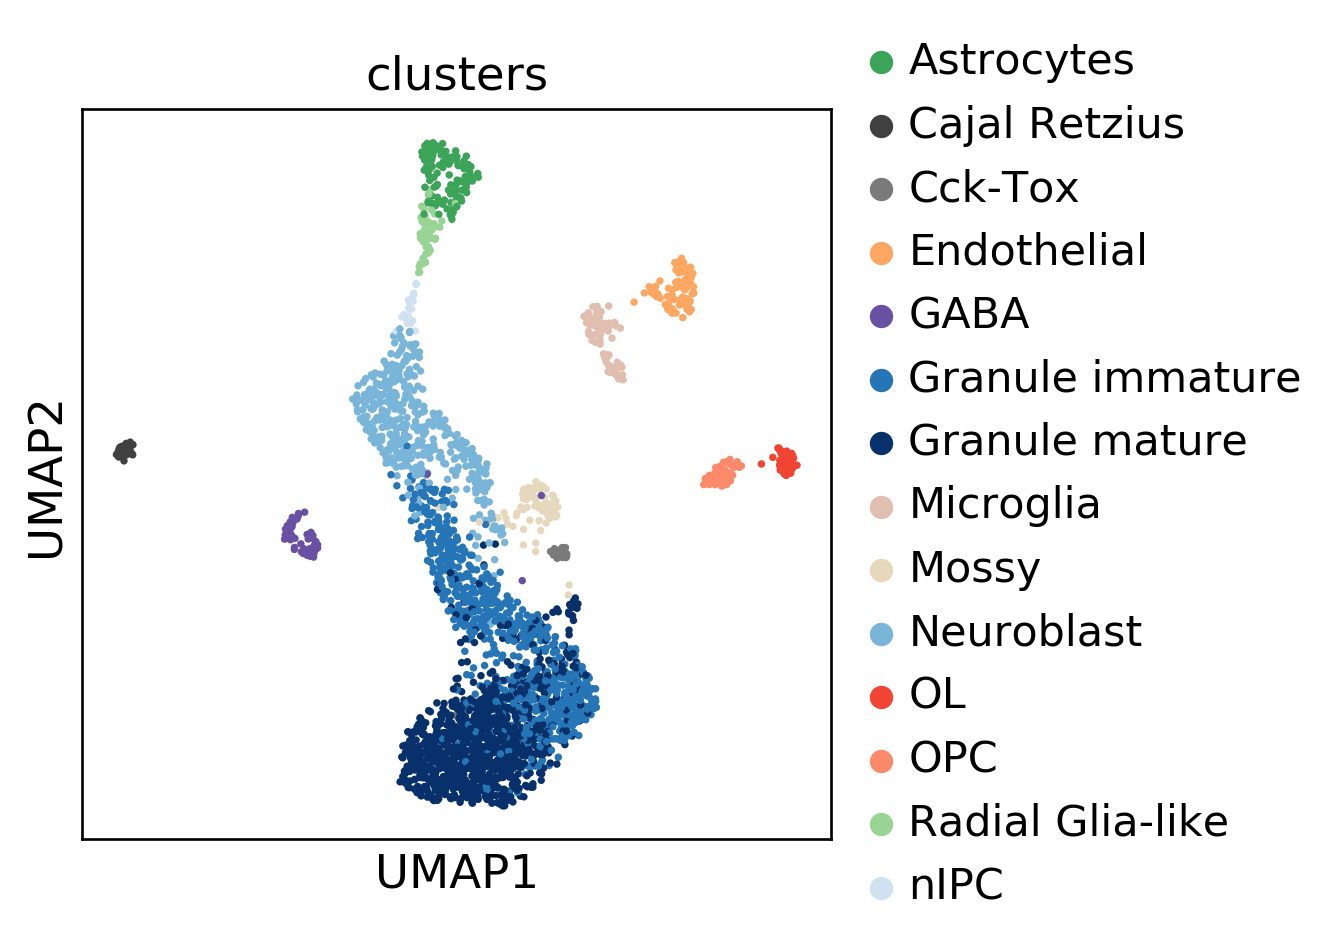

In [49]:
sc.pl.umap(adata, color="clusters", size=20)

In [73]:
df = pd.DataFrame(adata.X.A, columns=adata.var.index)
df = df.drop(["3110035E14Rik"], axis=1)
df.index.name = "Cell_ID"

In [74]:
df.head(20)

index    Lypla1  Tcea1  Atp6v1h  Rb1cc1  St18  Pcmtd1  Rrs1  Adhfe1  Sgk3  \
Cell_ID                                                                     
0           0.0    0.0      0.0     2.0   0.0     1.0   0.0     0.0   0.0   
1           0.0    1.0      0.0     0.0   0.0     0.0   0.0     0.0   0.0   
2           0.0    0.0      0.0     0.0   0.0     0.0   0.0     0.0   0.0   
3           0.0    0.0      0.0     0.0   0.0     1.0   0.0     0.0   0.0   
4           0.0    0.0      0.0     0.0   0.0     0.0   0.0     0.0   0.0   
5           0.0    0.0      0.0     1.0   0.0     0.0   0.0     0.0   0.0   
6           0.0    0.0      0.0     1.0   0.0     0.0   0.0     0.0   0.0   
7           0.0    0.0      0.0     0.0   0.0     0.0   1.0     0.0   0.0   
8           0.0    0.0      0.0     0.0   0.0     0.0   1.0     0.0   0.0   
9           0.0    0.0      0.0     0.0   0.0     0.0   1.0     0.0   0.0   
10          0.0    0.0      0.0     0.0   0.0     0.0   0.0     0.0   0.0   
11          0.0    0.0      1.0     0.0   0.0     0.0   0.0     0.0   0.0   
12          0.0    0.0      0.0     2.0   0.0     1.0   0.0     0.0   0.0   
13          0.0    0.0      0.0     0.0   0.0     0.0   0.0     0.0   0.0   
14          0.0    0.0      0.0     0.0   0.0     1.0   0.0     0.0   0.0   
15          0.0    0.0      0.0     0.0   0.0     0.0   0.0     0.0   0.0   
16          0.0    0.0      0.0     0.0   0.0     0.0   0.0     0.0   0.0   
17          0.0    0.0      0.0     0.0   0.0     1.0   0.0     0.0   0.0   
18          0.0    0.0      0.0     1.0   0.0     0.0   0.0     0.0   0.0   
19          0.0    0.0      2.0     0.0   0.0     1.0   0.0     0.0   0.0   

index    Mcmdc2  ...  Tlr7  Prps2  Frmpd4  Msl3  Hccs  Kdm5d  Eif2s3y  Erdr1  \
Cell_ID          ...                                                           
0           0.0  ...   0.0    0.0     0.0   0.0   0.0    0.0      0.0    0.0   
1           0.0  ...   0.0    0.0     0.0   0.0   0.0    0.0      0.0    0.0   
2           0.0  ...   0.0    0.0     0.0   0.0   0.0    0.0      0.0    0.0   
3           0.0  ...   0.0    0.0     0.0   0.0   0.0    0.0      0.0    0.0   
4           0.0  ...   0.0    0.0     0.0   0.0   0.0    0.0      0.0    0.0   
5           0.0  ...   0.0    0.0     0.0   0.0   0.0    0.0      0.0    2.0   
6           0.0  ...   0.0    0.0     0.0   0.0   0.0    0.0      0.0    0.0   
7           0.0  ...   0.0    0.0     1.0   0.0   0.0    0.0      0.0    0.0   
8           0.0  ...   0.0    0.0     0.0   0.0   0.0    0.0      0.0    0.0   
9           0.0  ...   0.0    0.0     0.0   0.0   0.0    1.0      0.0    0.0   
10          0.0  ...   0.0    0.0     0.0   0.0   0.0    0.0      0.0    0.0   
11          0.0  ...   0.0    0.0     0.0   0.0   0.0    0.0      0.0    0.0   
12          0.0  ...   0.0    0.0     0.0   0.0   0.0    0.0      0.0    0.0   
13          0.0  ...   0.0    0.0     0.0   0.0   0.0    0.0      0.0    1.0   
14          0.0  ...   0.0    0.0     0.0   0.0   0.0    0.0      0.0    0.0   
15          0.0  ...   0.0    0.0     0.0   0.0   0.0    0.0      0.0    1.0   
16          0.0  ...   0.0    0.0     0.0   0.0   0.0    0.0      0.0    0.0   
17          0.0  ...   0.0    0.0     0.0   0.0   0.0    0.0      0.0    0.0   
18          0.0  ...   0.0    0.0     0.0   0.0   0.0    0.0      0.0    0.0   
19          0.0  ...   0.0    0.0     0.0   0.0   0.0    0.0      0.0    1.0   

index    Uty  Ddx3y  
Cell_ID              
0        0.0    0.0  
1        0.0    0.0  
2        0.0    0.0  
3        0.0    0.0  
4        0.0    0.0  
5        0.0    0.0  
6        0.0    0.0  
7        0.0    0.0  
8        0.0    0.0  
9        0.0    0.0  
10       0.0    0.0  
11       0.0    0.0  
12       0.0    0.0  
13       0.0    0.0  
14       0.0    0.0  
15       0.0    0.0  
16       0.0    0.0  
17       0.0    0.0  
18       0.0    0.0  
19       0.0    0.0  

[20 rows x 13912 columns]